In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import pickle
from scipy import stats


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import categorical_crossentropy
import tensorflow_datasets as tfds

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler


%config IPCompleter.greedy=True

In [128]:
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_test, y_pred, Time = ApplyModel(X, y, model)
    
    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
    
    plt.figure(figsize = (16,6))
    plt.subplot(1,2,1)
    for i in range(cv.n_splits):
        _, y_test, y_pred, tim = ApplyModel(X, y, model)
        plt.scatter(y_test, y_pred,s=5,alpha=.1)
    axes = plt.gca()
    plt.xlim(0,
             max(axes.get_ylim()[1], axes.get_xlim()[1]))
    plt.ylim(axes.get_xlim())
    plt.plot(axes.get_xlim(),axes.get_ylim(), 'r--')
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std, Accuracy, Time)

def ApplyModel(X, y, model):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    Time = time.perf_counter()
    
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    
    return (model, y_test, y_pred, time.perf_counter() - Time)  

def PrintResults(model, X, y, title):
    
    start_time = time.perf_counter()
        
    _, Score_mean, Score_std, Accuracy, Time = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    print('Model Time: %.2f s'%(Time))
    print('Total Time: %.2f s'%(time.perf_counter() - start_time))
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std}, index = [0])
    return (model, Summary)

In [2]:
raw_data = pd.DataFrame()

In [3]:
for file in os.listdir('./'):
    if file.endswith('csv'):
        new_file = pd.read_csv(file)
        print(new_file)
        raw_data = raw_data.append(new_file, ignore_index=True)

       Unnamed: 0    timestamp  below_wall  above_wall  wall_distance  coin  \
0               0     1.366840           1           1            536     0   
1               1     1.400733           1           1            536     0   
2               2     1.432343           1           1            536     0   
3               3     1.470238           1           1            536     0   
4               4     1.499167           1           1            536     0   
...           ...          ...         ...         ...            ...   ...   
44087       44087  1507.251441           1           0            446     0   
44088       44088  1507.290303           1           0            441     0   
44089       44089  1507.328889           1           0            436     0   
44090       44090  1507.372535           1           0            431     0   
44091       44091  1507.412640           1           0            426     0   

       coin_y_offset  coin_distance  enemy  enemy_y

In [4]:
raw_data

,Unnamed: 0,timestamp,below_wall,above_wall,wall_distance,coin,coin_y_offset,coin_distance,enemy,enemy_y_offset,enemy_distance,enemy_velocity,shot,k_up,k_down,k_space,SCORE
0,0,1.366840,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0
1,1,1.400733,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0
2,2,1.432343,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0
3,3,1.470238,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0
4,4,1.499167,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186063,68367,2554.295322,1,1,246,1,-1,108,0,0,-1,0,0,0,0,0,0
186064,68368,2554.334846,1,1,241,1,-1,103,0,0,-1,0,0,0,0,0,0
186065,68369,2554.376226,1,1,236,1,-1,98,0,0,-1,0,0,0,0,0,0
186066,68370,2554.417427,1,1,231,1,-1,93,1,-24,545,1,0,0,0,0,0


In [5]:
def strClass(row):
    str_class = ''
    if row['k_up'] == 1:
        str_class += 'Up'
    if row['k_down'] == 1:
        str_class += 'Down'
    if row['k_space'] == 1:
        str_class += 'Space'
    if str_class == '':
        str_class = 'None'
    return str_class

In [6]:
raw_data['class'] = raw_data.apply(lambda row: strClass(row), axis=1)

In [7]:
raw_data.head()

,Unnamed: 0,timestamp,below_wall,above_wall,wall_distance,coin,coin_y_offset,coin_distance,enemy,enemy_y_offset,enemy_distance,enemy_velocity,shot,k_up,k_down,k_space,SCORE,class
0,0,1.366840,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0,None
1,1,1.400733,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0,None
2,2,1.432343,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0,None
3,3,1.470238,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0,None
4,4,1.499167,1,1,536,0,0,-1,0,0,-1,0,0,0,0,0,0,None


In [8]:
data = raw_data.drop(columns=['Unnamed: 0','timestamp','SCORE','k_up','k_down','k_space'])

In [9]:
data.head()

,below_wall,above_wall,wall_distance,coin,coin_y_offset,coin_distance,enemy,enemy_y_offset,enemy_distance,enemy_velocity,shot,class
0,1,1,536,0,0,-1,0,0,-1,0,0,None
1,1,1,536,0,0,-1,0,0,-1,0,0,None
2,1,1,536,0,0,-1,0,0,-1,0,0,None
3,1,1,536,0,0,-1,0,0,-1,0,0,None
4,1,1,536,0,0,-1,0,0,-1,0,0,None


Text(0.5, 1.0, 'Class distribution in data set')

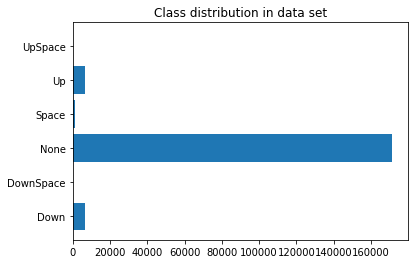

In [10]:
classes, counts = np.unique(data['class'], return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in data set')

In [11]:
print(classes, counts)

['Down' 'DownSpace' 'None' 'Space' 'Up' 'UpSpace'] [  6749     54 171077   1336   6802     50]


In [12]:
X = data.drop(columns='class')
y = data['class']
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(X_scaled)

In [214]:
pickle.dump(min_max_scaler, open('scaler.sav', 'wb'))

In [13]:
def printConfMatrix(actual, predicted, classes):
    C = confusion_matrix(pred, actual)
    C = 100*C / C.astype(np.float).sum(axis=0)
    plt.figure(figsize=(10,7))
    ax = plt.axes()
    sns.heatmap(C, annot=True,
                annot_kws={"size": 15},
                xticklabels=classes, 
               yticklabels=classes, ax = ax,
               fmt='.0f')
    ax.set_title('Confusion matrix (%)')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.show()

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Random Forest

0.9940882463588971


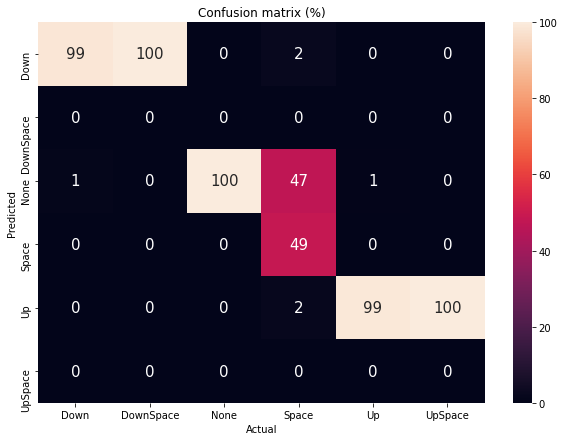

In [192]:
forest_base = RandomForestClassifier(n_jobs=-1)
forest_base.fit(X_train, y_train)
print(forest_base.score(X_test, y_test))
pred = forest_base.predict(X_test)
printConfMatrix(y_test, pred, classes)

0.9941151179663568


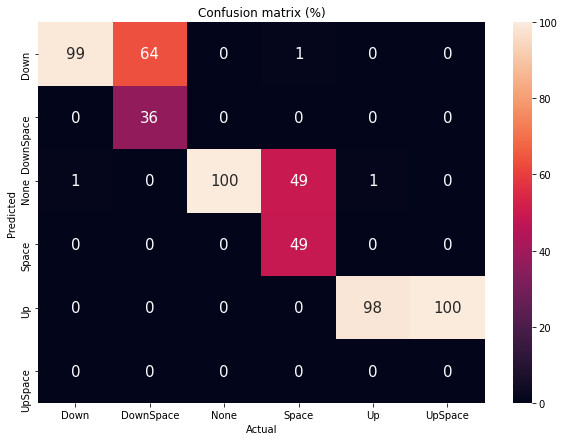

In [17]:
forest_opt0 = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
forest_opt0.fit(X_train, y_train)
print(forest_opt0.score(X_test, y_test))
pred = forest_opt0.predict(X_test)
printConfMatrix(y_test, pred, classes)

0.9937120438544633


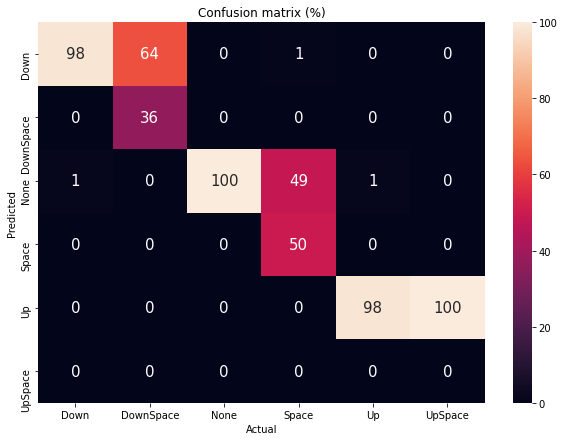

In [106]:
forest_opt1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')
forest_opt1.fit(X_train, y_train)
print(forest_opt1.score(X_test, y_test))
pred = forest_opt1.predict(X_test)
printConfMatrix(y_test, pred, classes)

0.993980759929059


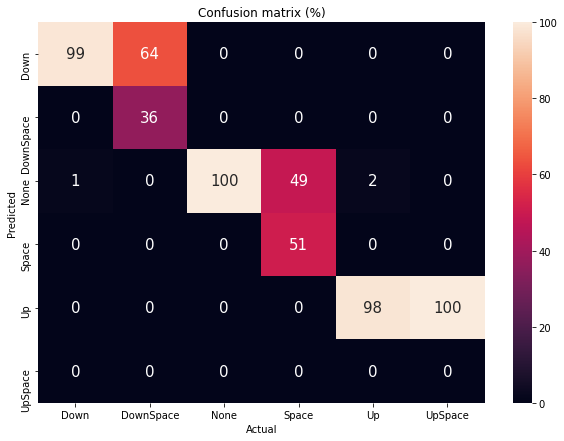

In [107]:
forest_opt2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced_subsample')
forest_opt2.fit(X_train, y_train)
print(forest_opt2.score(X_test, y_test))
pred = forest_opt2.predict(X_test)
printConfMatrix(y_test, pred, classes)

Text(0.5, 1.0, 'Class distribution in oversampled data set')

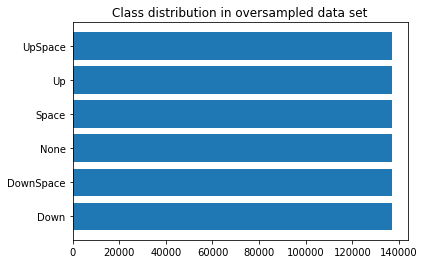

In [80]:
oversample = SMOTE(n_jobs=-1)
X_train_O, y_train_O = oversample.fit_resample(X_train, y_train)
classes, counts = np.unique(y_train_O, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in oversampled data set')

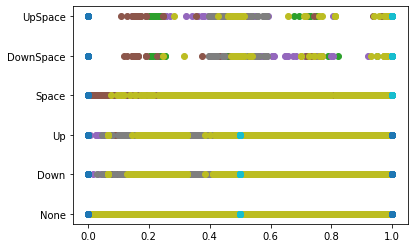

In [102]:
# plot the data
plt.plot(X_train.to_numpy(),y_train, 'o')

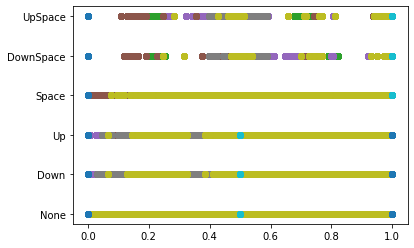

In [103]:
plt.plot(X_train_O.to_numpy(),y_train_O, 'o')

0.9946525501155479


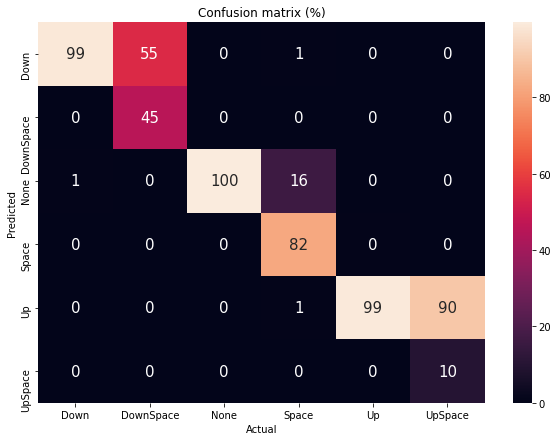

In [81]:
forest_opt3 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest_opt3.fit(X_train_O, y_train_O)
print(forest_opt3.score(X_test, y_test))
pred = forest_opt3.predict(X_test)
printConfMatrix(y_test, pred, classes)

0.994706293330467


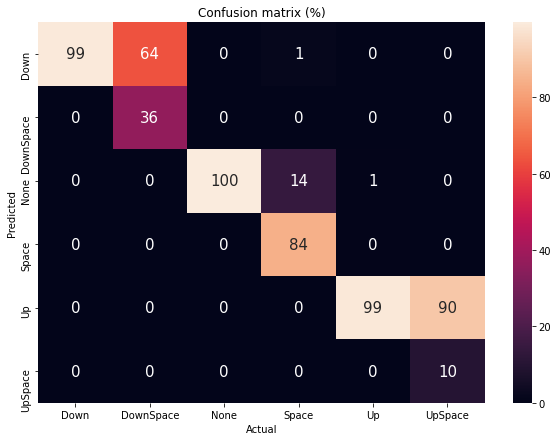

In [82]:
forest_opt4 = RandomForestClassifier(n_estimators=15, n_jobs=-1)
forest_opt4.fit(X_train_O, y_train_O)
print(forest_opt4.score(X_test, y_test))
pred = forest_opt4.predict(X_test)
printConfMatrix(y_test, pred, classes)

Text(0.5, 1.0, 'Class distribution in oversampled data set')

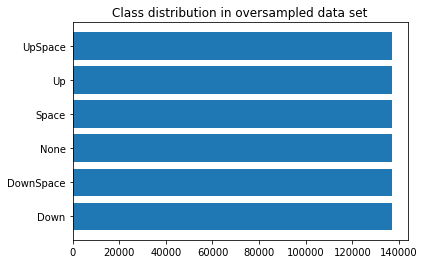

In [104]:
oversample = RandomOverSampler()
X_train_O, y_train_O = oversample.fit_resample(X_train, y_train)
classes, counts = np.unique(y_train_O, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in oversampled data set')

0.9941957327887354


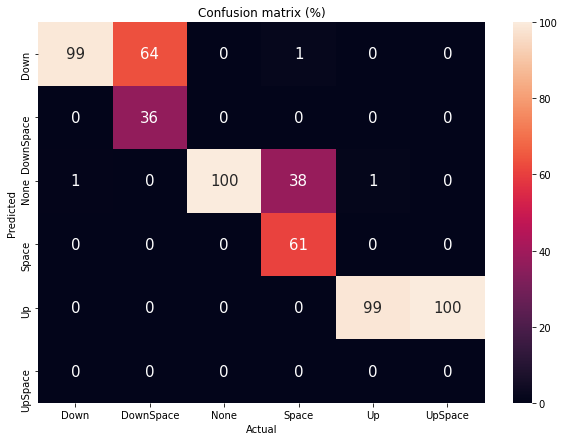

In [105]:
forest_opt5 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest_opt5.fit(X_train_O, y_train_O)
print(forest_opt5.score(X_test, y_test))
pred = forest_opt5.predict(X_test)
printConfMatrix(y_test, pred, classes)

['Down' 'DownSpace' 'None' 'Space' 'Up' 'UpSpace'] [5399   43 6000 1069 5442   40]


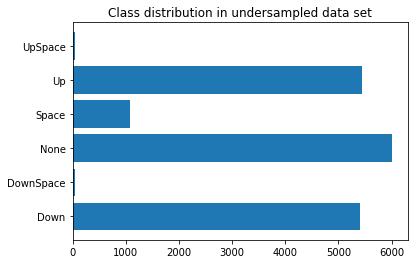

In [193]:
undersample = RandomUnderSampler(sampling_strategy={'None':6000})
X_train_U, y_train_U = undersample.fit_resample(X_train, y_train)
classes, counts = np.unique(y_train_U, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in undersampled data set')
print(classes, counts)

Text(0.5, 1.0, 'Class distribution in oversampled data set')

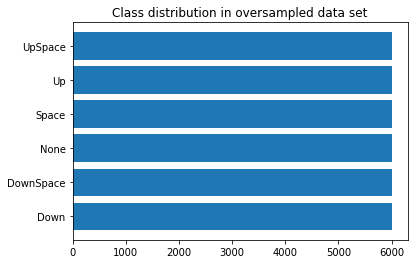

In [194]:
oversample = SMOTE(n_jobs=-1)
X_train_O, y_train_O = oversample.fit_resample(X_train_U, y_train_U)
classes, counts = np.unique(y_train_O, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in oversampled data set')

0.9835008330198313


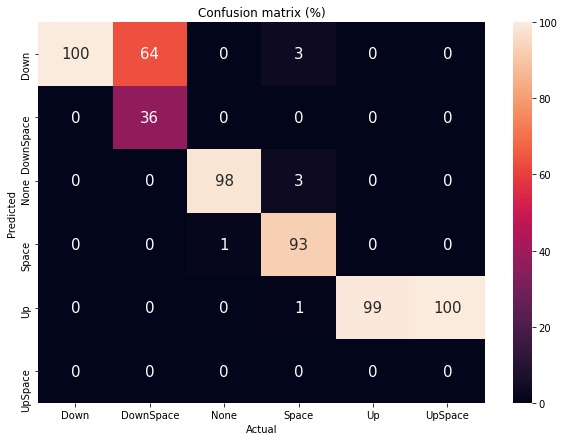

In [120]:
forest_opt6 = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced_subsample')
forest_opt6.fit(X_train_U, y_train_U)
print(forest_opt6.score(X_test, y_test))
pred = forest_opt6.predict(X_test)
printConfMatrix(y_test, pred, classes)

0.9797388079754931


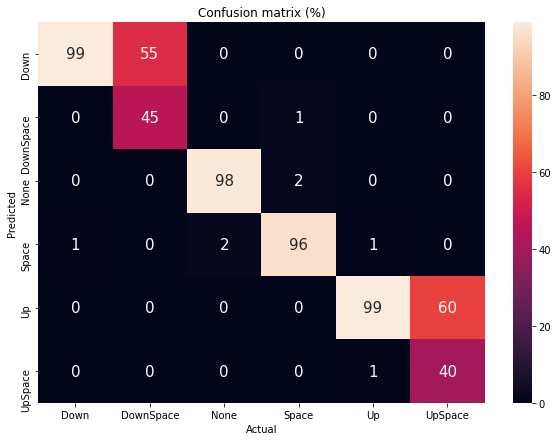

In [123]:
forest_opt7 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest_opt7.fit(X_train_O, y_train_O)
print(forest_opt7.score(X_test, y_test))
pred = forest_opt7.predict(X_test)
printConfMatrix(y_test, pred, classes)

0.9746063309507175
Model 1


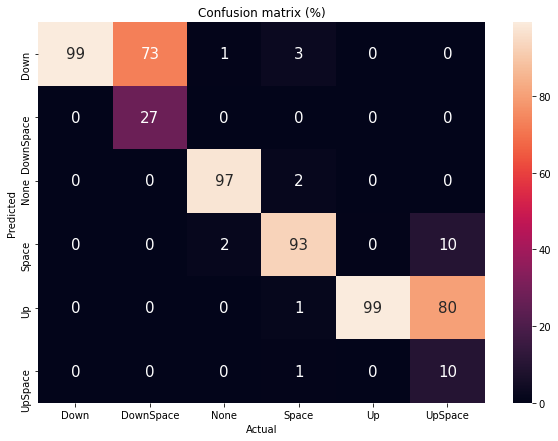

0.9756005804267212
Model 2


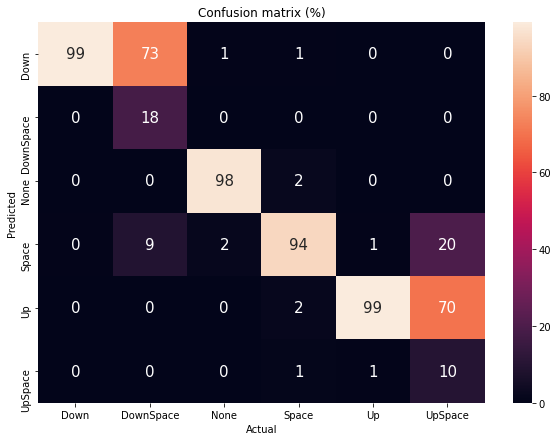

0.9753587359595851
Model 3


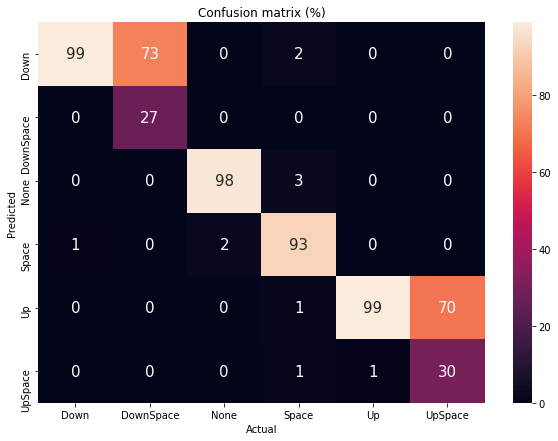

0.9740151555866072
Model 4


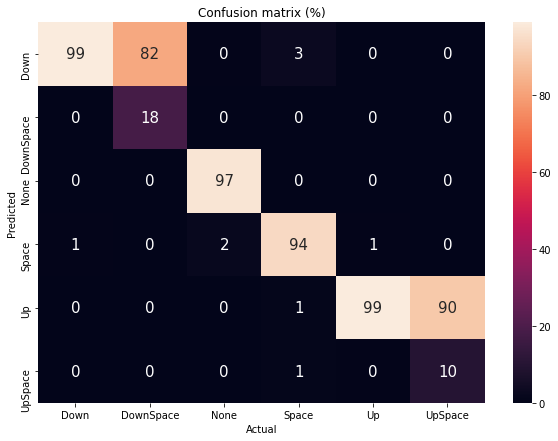

0.9730209061106035
Model 5


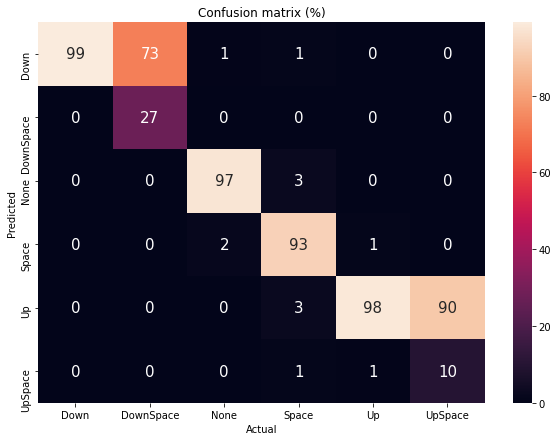

0.9741226420164454
Model 6


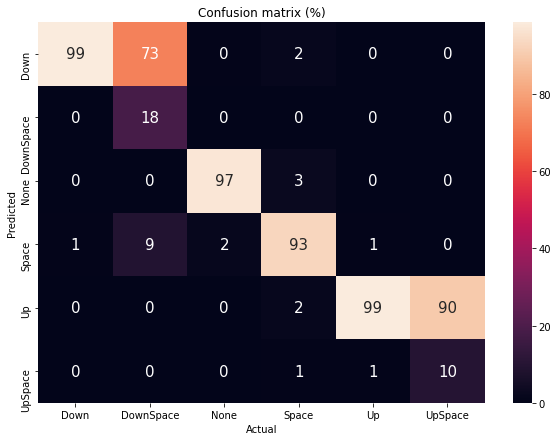

0.9749287902402322
Model 7


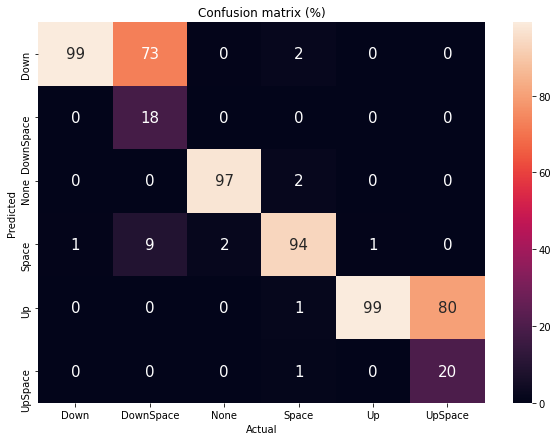

0.9782339979577578
Model 8


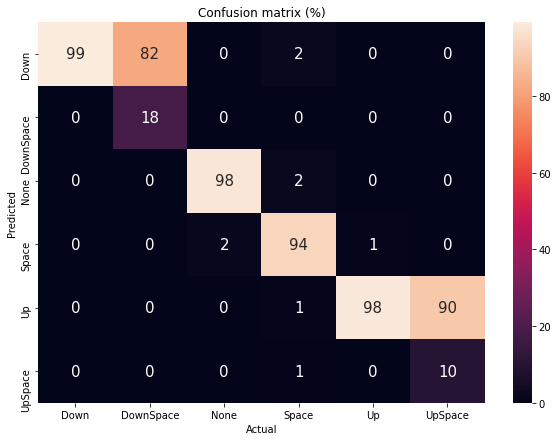

0.9756274520341807
Model 9


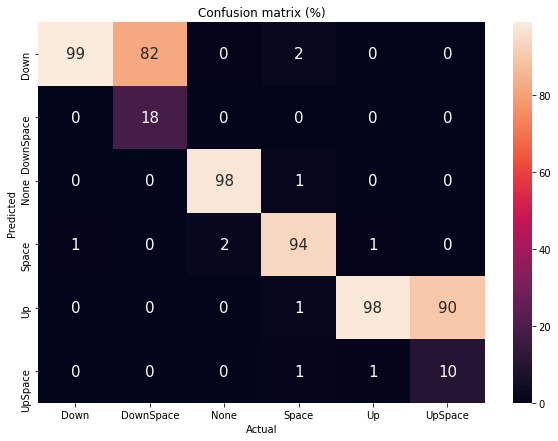

0.9753318643521256
Model 10


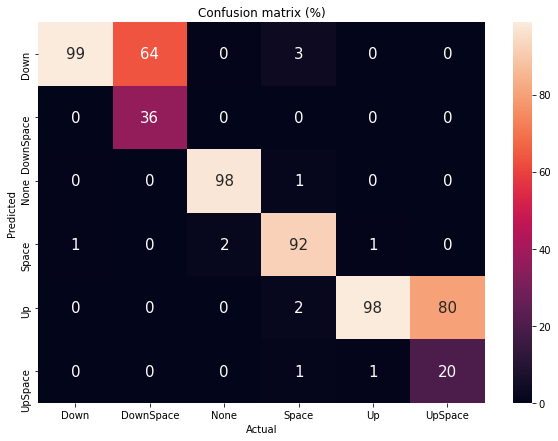

In [195]:
models = []
for i in range(1,11):
    curr_model = RandomForestClassifier(n_estimators=10, n_jobs=-1)
    curr_model.fit(X_train_O, y_train_O)
    print(curr_model.score(X_test, y_test))
    pred = curr_model.predict(X_test)
    print('Model ' + str(i))
    printConfMatrix(y_test, pred, classes)
    models.append(curr_model)

In [197]:
pickle.dump(models[9], open('forest_opt.sav', 'wb'))
# %run GameWrapper.py a forest_opt.sav

# Tensorflow

In [29]:
ord_enc = OrdinalEncoder(dtype=np.int64)
ord_enc.fit(y_train.to_frame())
ord_enc.fit(y_test.to_frame())
y_train_int = ord_enc.transform(y_train.to_frame())
y_test_int = ord_enc.transform(y_test.to_frame())

In [30]:
y_cat = y_test.astype('category')
pd.Categorical(y_cat).categories
class_names = pd.Categorical(y_cat).categories
class_names

Index(['Down', 'DownSpace', 'None', 'Space', 'Up', 'UpSpace'], dtype='object')

In [31]:
train_df = X_train.copy()
train_df['class'] = y_train_int
test_df = X_test.copy()
test_df['class'] = y_test_int

In [32]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df.drop(columns='class').values, train_df['class'].values))
val_ds = tf.data.Dataset.from_tensor_slices((test_df.drop(columns='class').values, test_df['class'].values))

In [33]:
train_ds_large = train_ds.batch(4096).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_large = val_ds.batch(4096).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

num_classes = 6
tmodels = {}
results = {}

In [55]:
val_X = X_test.to_numpy()
def printGraphs(m, X, y, result, epochs):
    val_pred = m.predict(X)
    temp = []
    for i in range(0, len(val_pred)):
        num = np.argmax(val_pred[i])
        temp.append(class_names[num])
    val_pred = pd.Series(data=temp)
    
    C = confusion_matrix(val_pred, y)
    C = 100*C / C.astype(np.float).sum(axis=0)
    plt.figure(figsize=(10,7))
    ax = plt.axes()
    sns.heatmap(C, annot=True,
                annot_kws={"size": 15},
                xticklabels=classes, 
               yticklabels=classes, ax = ax,
               fmt='.0f')
    ax.set_title('Confusion matrix (%)')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.show()
    
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    epochs_range = range(epochs)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_ybound(upper=1,lower=.5)
    plt.title('Training and Validation Accuracy')

    ax = plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.title('Training and Validation Loss')
    plt.show()

In [149]:
tmodels['base'] = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['base'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['base'] = tmodels['base'].fit(train_ds_large,
               validation_data=val_ds_large,
               epochs=100)

Epoch 1/100
37/37 [==============================] - 1s 9ms/step - loss: 1.2355 - accuracy: 0.9025 - val_loss: 0.4779 - val_accuracy: 0.9194
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 0.4344 - accuracy: 0.9189 - val_loss: 0.3708 - val_accuracy: 0.9194
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.9189 - val_loss: 0.3312 - val_accuracy: 0.9194
Epoch 4/100
37/37 [==============================] - 0s 3ms/step - loss: 0.3257 - accuracy: 0.9189 - val_loss: 0.3115 - val_accuracy: 0.9194
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 0.3088 - accuracy: 0.9189 - val_loss: 0.2998 - val_accuracy: 0.9194
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 0.2982 - accuracy: 0.9189 - val_loss: 0.2919 - val_accuracy: 0.9194
Epoch 7/100
37/37 [==============================] - 0s 3ms/step - loss: 0.2905 - accuracy: 0.9189 - val_loss: 0.2853 - val_accuracy: 0.9194
Epoch 8/100
3

37/37 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9493 - val_loss: 0.1505 - val_accuracy: 0.9494
Epoch 59/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1486 - accuracy: 0.9497 - val_loss: 0.1494 - val_accuracy: 0.9498
Epoch 60/100
37/37 [==============================] - 0s 3ms/step - loss: 0.1475 - accuracy: 0.9502 - val_loss: 0.1483 - val_accuracy: 0.9503
Epoch 61/100
37/37 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9508 - val_loss: 0.1471 - val_accuracy: 0.9509
Epoch 62/100
37/37 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9514 - val_loss: 0.1460 - val_accuracy: 0.9514
Epoch 63/100
37/37 [==============================] - 0s 4ms/step - loss: 0.1441 - accuracy: 0.9518 - val_loss: 0.1449 - val_accuracy: 0.9521
Epoch 64/100
37/37 [==============================] - 0s 3ms/step - loss: 0.1430 - accuracy: 0.9522 - val_loss: 0.1438 - val_accuracy: 0.9525
Epoch 65/100
37/37 

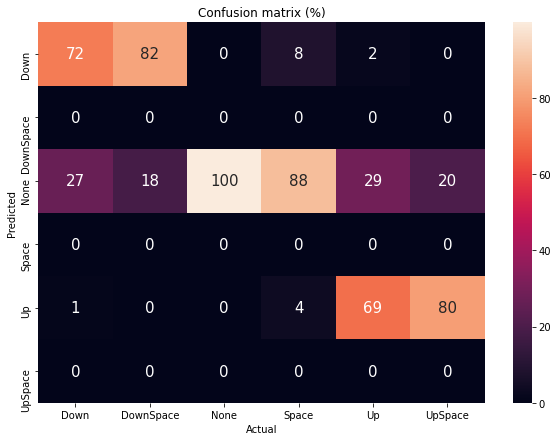

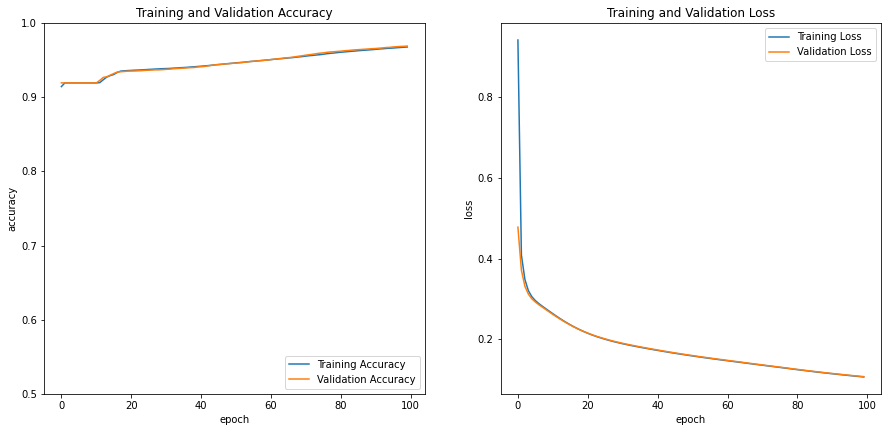

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_50 (Dense)             (None, 6)                 774       
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
_________________________________________________________________


In [151]:
printGraphs(tmodels['base'], val_X, y_test, results['base'], 100)
tmodels['base'].summary()

In [39]:
y[y == class_names[0]].count()

6749

In [40]:
total = y.count()
weights = {}
for i in range(0, 6):
    c = y[y == class_names[i]].count()
    weights[i] = (1 / c)*(total)/2.0
weights

{0: 13.7848570158542,
 1: 1722.8518518518517,
 2: 0.5438136044003578,
 3: 69.63622754491018,
 4: 13.677447809467802,
 5: 1860.68}

In [163]:
tmodels['0'] = tf.keras.Sequential([    
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['0'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['0'] = tmodels['0'].fit(train_ds_large,
               validation_data=val_ds_large,
               epochs=100,
               class_weight=weights)

Epoch 1/100
37/37 [==============================] - 0s 6ms/step - loss: 5.2431 - accuracy: 0.3613 - val_loss: 1.6041 - val_accuracy: 0.4970
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 4.8023 - accuracy: 0.4909 - val_loss: 1.4232 - val_accuracy: 0.5159
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 4.4302 - accuracy: 0.5075 - val_loss: 1.3269 - val_accuracy: 0.5166
Epoch 4/100
37/37 [==============================] - 0s 3ms/step - loss: 4.1393 - accuracy: 0.5097 - val_loss: 1.2565 - val_accuracy: 0.5171
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 3.9351 - accuracy: 0.5105 - val_loss: 1.2187 - val_accuracy: 0.5167
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 3.7926 - accuracy: 0.5105 - val_loss: 1.1880 - val_accuracy: 0.5165
Epoch 7/100
37/37 [==============================] - 0s 3ms/step - loss: 3.6861 - accuracy: 0.5107 - val_loss: 1.1683 - val_accuracy: 0.5163
Epoch 8/100
3

Epoch 59/100
37/37 [==============================] - 0s 3ms/step - loss: 2.1621 - accuracy: 0.5902 - val_loss: 0.7963 - val_accuracy: 0.5899
Epoch 60/100
37/37 [==============================] - 0s 3ms/step - loss: 2.1472 - accuracy: 0.5925 - val_loss: 0.7905 - val_accuracy: 0.5955
Epoch 61/100
37/37 [==============================] - 0s 3ms/step - loss: 2.1301 - accuracy: 0.5976 - val_loss: 0.7923 - val_accuracy: 0.5956
Epoch 62/100
37/37 [==============================] - 0s 3ms/step - loss: 2.1138 - accuracy: 0.5995 - val_loss: 0.7821 - val_accuracy: 0.6011
Epoch 63/100
37/37 [==============================] - 0s 3ms/step - loss: 2.0998 - accuracy: 0.6040 - val_loss: 0.7787 - val_accuracy: 0.6034
Epoch 64/100
37/37 [==============================] - 0s 3ms/step - loss: 2.0839 - accuracy: 0.6059 - val_loss: 0.7780 - val_accuracy: 0.6047
Epoch 65/100
37/37 [==============================] - 0s 3ms/step - loss: 2.0690 - accuracy: 0.6083 - val_loss: 0.7714 - val_accuracy: 0.6086
Epoch 

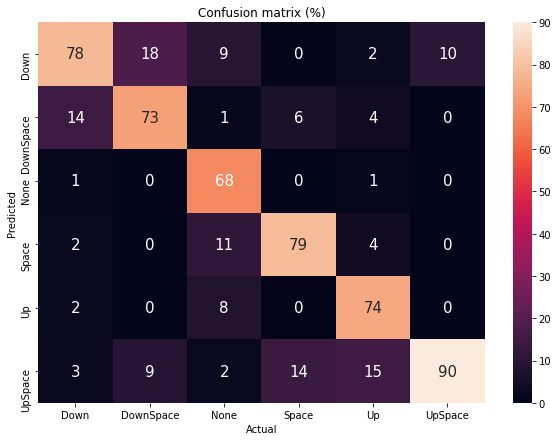

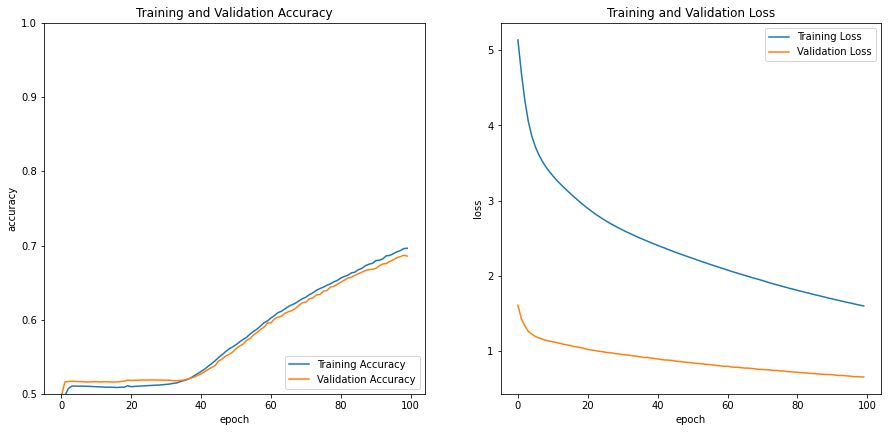

In [164]:
printGraphs(tmodels['0'], val_X, y_test, results['0'], 100)

In [165]:
tmodels['1'] = tf.keras.Sequential([    
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['1'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['1'] = tmodels['1'].fit(train_ds_large,
               validation_data=val_ds_large,
               epochs=100,
               class_weight=weights)

Epoch 1/100
37/37 [==============================] - 1s 8ms/step - loss: 5.2053 - accuracy: 0.1394 - val_loss: 1.4790 - val_accuracy: 0.4610
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 4.3312 - accuracy: 0.4742 - val_loss: 1.3787 - val_accuracy: 0.5076
Epoch 3/100
37/37 [==============================] - 0s 5ms/step - loss: 3.7618 - accuracy: 0.5079 - val_loss: 1.3257 - val_accuracy: 0.5107
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 3.4512 - accuracy: 0.5095 - val_loss: 1.2647 - val_accuracy: 0.5075
Epoch 5/100
37/37 [==============================] - 0s 4ms/step - loss: 3.2490 - accuracy: 0.5048 - val_loss: 1.2119 - val_accuracy: 0.5093
Epoch 6/100
37/37 [==============================] - 0s 4ms/step - loss: 3.0927 - accuracy: 0.5056 - val_loss: 1.1836 - val_accuracy: 0.5092
Epoch 7/100
37/37 [==============================] - 0s 5ms/step - loss: 2.9589 - accuracy: 0.5064 - val_loss: 1.1429 - val_accuracy: 0.5100
Epoch 8/100
3

Epoch 59/100
37/37 [==============================] - 0s 5ms/step - loss: 0.7828 - accuracy: 0.8598 - val_loss: 0.3710 - val_accuracy: 0.8589
Epoch 60/100
37/37 [==============================] - 0s 4ms/step - loss: 0.7685 - accuracy: 0.8622 - val_loss: 0.3612 - val_accuracy: 0.8641
Epoch 61/100
37/37 [==============================] - 0s 4ms/step - loss: 0.7506 - accuracy: 0.8657 - val_loss: 0.3565 - val_accuracy: 0.8663
Epoch 62/100
37/37 [==============================] - 0s 5ms/step - loss: 0.7351 - accuracy: 0.8673 - val_loss: 0.3496 - val_accuracy: 0.8688
Epoch 63/100
37/37 [==============================] - 0s 4ms/step - loss: 0.7194 - accuracy: 0.8709 - val_loss: 0.3462 - val_accuracy: 0.8701
Epoch 64/100
37/37 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.8723 - val_loss: 0.3347 - val_accuracy: 0.8743
Epoch 65/100
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.8757 - val_loss: 0.3404 - val_accuracy: 0.8736
Epoch 

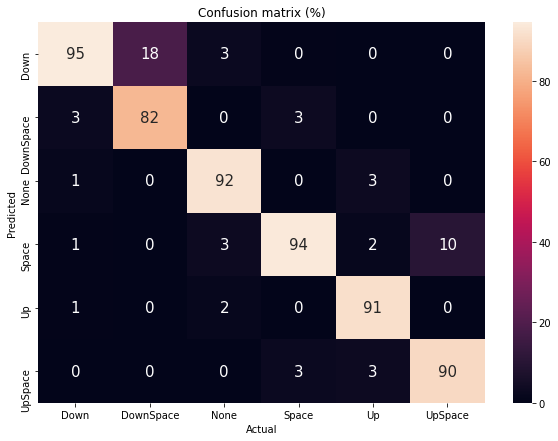

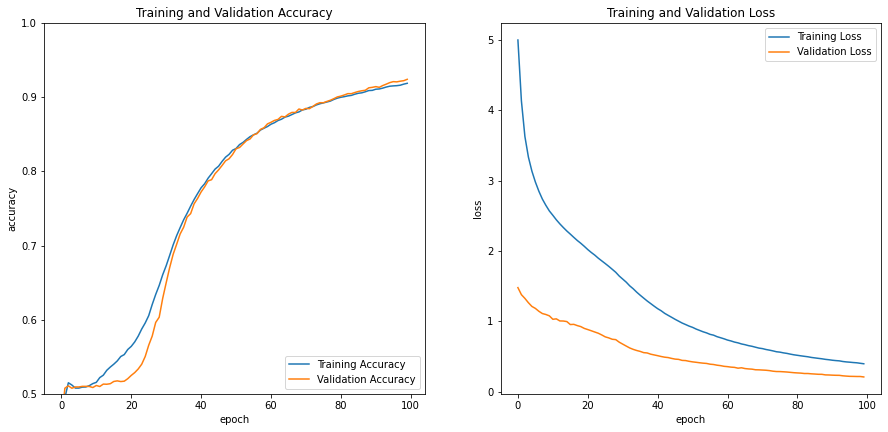

In [168]:
printGraphs(tmodels['1'], val_X, y_test, results['1'], 100)

In [169]:
tmodels['2'] = tf.keras.Sequential([    
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['2'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['2'] = tmodels['2'].fit(train_ds_large,
               validation_data=val_ds_large,
               epochs=100,
               class_weight=weights)

Epoch 1/100
37/37 [==============================] - 1s 9ms/step - loss: 5.1846 - accuracy: 0.3480 - val_loss: 1.4181 - val_accuracy: 0.4981
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 4.0087 - accuracy: 0.5018 - val_loss: 1.1040 - val_accuracy: 0.5153
Epoch 3/100
37/37 [==============================] - 0s 7ms/step - loss: 3.4046 - accuracy: 0.5264 - val_loss: 1.0898 - val_accuracy: 0.5087
Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 3.1178 - accuracy: 0.5163 - val_loss: 1.0191 - val_accuracy: 0.5108
Epoch 5/100
37/37 [==============================] - 0s 6ms/step - loss: 2.9260 - accuracy: 0.5266 - val_loss: 0.9687 - val_accuracy: 0.5214
Epoch 6/100
37/37 [==============================] - 0s 6ms/step - loss: 2.7638 - accuracy: 0.5392 - val_loss: 0.9297 - val_accuracy: 0.5233
Epoch 7/100
37/37 [==============================] - 0s 6ms/step - loss: 2.6447 - accuracy: 0.5464 - val_loss: 0.8779 - val_accuracy: 0.5406
Epoch 8/100
3

Epoch 59/100
37/37 [==============================] - 0s 6ms/step - loss: 0.3127 - accuracy: 0.9357 - val_loss: 0.1580 - val_accuracy: 0.9414
Epoch 60/100
37/37 [==============================] - 0s 6ms/step - loss: 0.2955 - accuracy: 0.9402 - val_loss: 0.1606 - val_accuracy: 0.9418
Epoch 61/100
37/37 [==============================] - 0s 6ms/step - loss: 0.2989 - accuracy: 0.9397 - val_loss: 0.1612 - val_accuracy: 0.9395
Epoch 62/100
37/37 [==============================] - 0s 6ms/step - loss: 0.2821 - accuracy: 0.9416 - val_loss: 0.1572 - val_accuracy: 0.9433
Epoch 63/100
37/37 [==============================] - 0s 6ms/step - loss: 0.2816 - accuracy: 0.9430 - val_loss: 0.1580 - val_accuracy: 0.9427
Epoch 64/100
37/37 [==============================] - 0s 6ms/step - loss: 0.2824 - accuracy: 0.9432 - val_loss: 0.1562 - val_accuracy: 0.9437
Epoch 65/100
37/37 [==============================] - 0s 7ms/step - loss: 0.2685 - accuracy: 0.9451 - val_loss: 0.1555 - val_accuracy: 0.9454
Epoch 

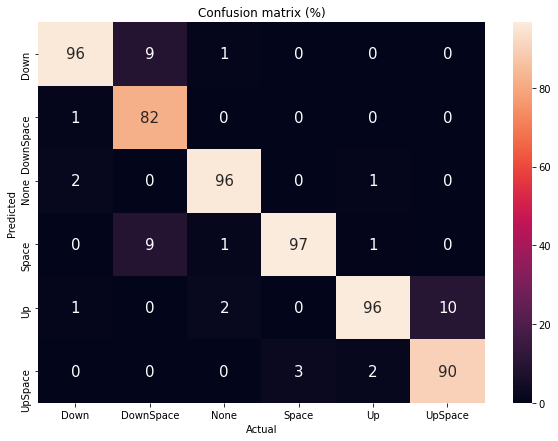

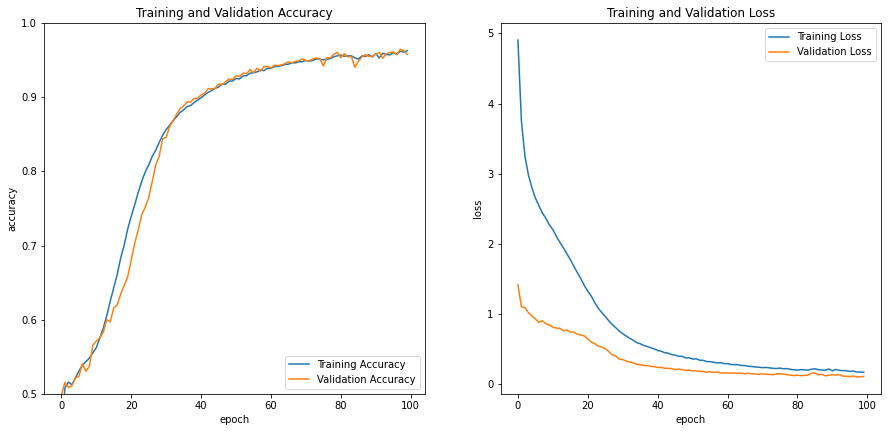

In [170]:
printGraphs(tmodels['2'], val_X, y_test, results['2'], 100)

In [171]:
tmodels['3'] = tf.keras.Sequential([    
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['3'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['3'] = tmodels['3'].fit(train_ds_large,
               validation_data=val_ds_large,
               epochs=100,
               class_weight=weights)

Epoch 1/100
37/37 [==============================] - 1s 13ms/step - loss: 5.0788 - accuracy: 0.3420 - val_loss: 1.3515 - val_accuracy: 0.5099
Epoch 2/100
37/37 [==============================] - 0s 10ms/step - loss: 3.7911 - accuracy: 0.5067 - val_loss: 1.1144 - val_accuracy: 0.5158
Epoch 3/100
37/37 [==============================] - 0s 10ms/step - loss: 3.3371 - accuracy: 0.5241 - val_loss: 1.0882 - val_accuracy: 0.5140
Epoch 4/100
37/37 [==============================] - 0s 10ms/step - loss: 3.0889 - accuracy: 0.5248 - val_loss: 1.0439 - val_accuracy: 0.5128
Epoch 5/100
37/37 [==============================] - 0s 10ms/step - loss: 2.9066 - accuracy: 0.5347 - val_loss: 0.9918 - val_accuracy: 0.5139
Epoch 6/100
37/37 [==============================] - 0s 10ms/step - loss: 2.7701 - accuracy: 0.5399 - val_loss: 0.9694 - val_accuracy: 0.5186
Epoch 7/100
37/37 [==============================] - 0s 10ms/step - loss: 2.6537 - accuracy: 0.5515 - val_loss: 0.9533 - val_accuracy: 0.5197
Epoch 

37/37 [==============================] - 0s 10ms/step - loss: 0.4382 - accuracy: 0.9128 - val_loss: 0.2195 - val_accuracy: 0.9205
Epoch 59/100
37/37 [==============================] - 0s 10ms/step - loss: 0.4322 - accuracy: 0.9143 - val_loss: 0.2114 - val_accuracy: 0.9236
Epoch 60/100
37/37 [==============================] - 0s 11ms/step - loss: 0.4210 - accuracy: 0.9161 - val_loss: 0.2100 - val_accuracy: 0.9238
Epoch 61/100
37/37 [==============================] - 0s 10ms/step - loss: 0.4138 - accuracy: 0.9188 - val_loss: 0.2046 - val_accuracy: 0.9260
Epoch 62/100
37/37 [==============================] - 0s 10ms/step - loss: 0.4038 - accuracy: 0.9193 - val_loss: 0.2037 - val_accuracy: 0.9266
Epoch 63/100
37/37 [==============================] - 0s 10ms/step - loss: 0.3999 - accuracy: 0.9217 - val_loss: 0.1965 - val_accuracy: 0.9283
Epoch 64/100
37/37 [==============================] - 0s 10ms/step - loss: 0.3876 - accuracy: 0.9233 - val_loss: 0.2026 - val_accuracy: 0.9253
Epoch 65/100

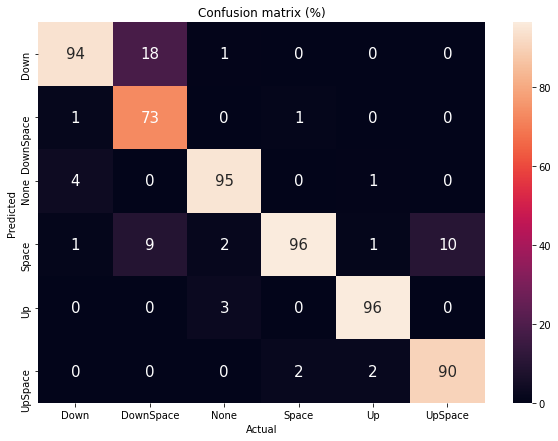

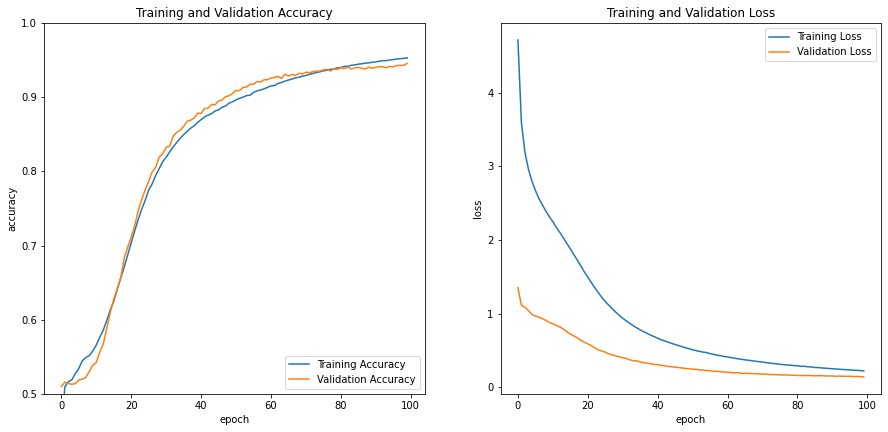

In [172]:
printGraphs(tmodels['3'], val_X, y_test, results['3'], 100)

In [173]:
train_ds_xl = train_ds.batch(18607).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_xl = val_ds.batch(18607).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [175]:
tmodels['4'] = tf.keras.Sequential([  
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['4'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['4'] = tmodels['4'].fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=100,
               class_weight=weights)

Epoch 1/100
8/8 [==============================] - 1s 36ms/step - loss: 5.3374 - accuracy: 0.0465 - val_loss: 1.7658 - val_accuracy: 0.4945
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 5.0418 - accuracy: 0.4881 - val_loss: 1.6406 - val_accuracy: 0.4990
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 4.7653 - accuracy: 0.4948 - val_loss: 1.5611 - val_accuracy: 0.5022
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 4.4745 - accuracy: 0.4970 - val_loss: 1.4286 - val_accuracy: 0.5134
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 4.1850 - accuracy: 0.5117 - val_loss: 1.3237 - val_accuracy: 0.5272
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 3.9364 - accuracy: 0.5221 - val_loss: 1.2590 - val_accuracy: 0.5246
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 3.7368 - accuracy: 0.5181 - val_loss: 1.1989 - val_accuracy: 0.5180
Epoch 8/100
8/8 [===

8/8 [==============================] - 0s 24ms/step - loss: 1.8235 - accuracy: 0.6247 - val_loss: 0.7141 - val_accuracy: 0.6437
Epoch 60/100
8/8 [==============================] - 0s 23ms/step - loss: 1.8056 - accuracy: 0.6319 - val_loss: 0.7173 - val_accuracy: 0.6425
Epoch 61/100
8/8 [==============================] - 0s 25ms/step - loss: 1.7868 - accuracy: 0.6332 - val_loss: 0.7087 - val_accuracy: 0.6469
Epoch 62/100
8/8 [==============================] - 0s 25ms/step - loss: 1.7691 - accuracy: 0.6379 - val_loss: 0.7086 - val_accuracy: 0.6467
Epoch 63/100
8/8 [==============================] - 0s 25ms/step - loss: 1.7518 - accuracy: 0.6397 - val_loss: 0.6963 - val_accuracy: 0.6544
Epoch 64/100
8/8 [==============================] - 0s 26ms/step - loss: 1.7326 - accuracy: 0.6433 - val_loss: 0.6920 - val_accuracy: 0.6572
Epoch 65/100
8/8 [==============================] - 0s 24ms/step - loss: 1.7149 - accuracy: 0.6489 - val_loss: 0.6879 - val_accuracy: 0.6598
Epoch 66/100
8/8 [========

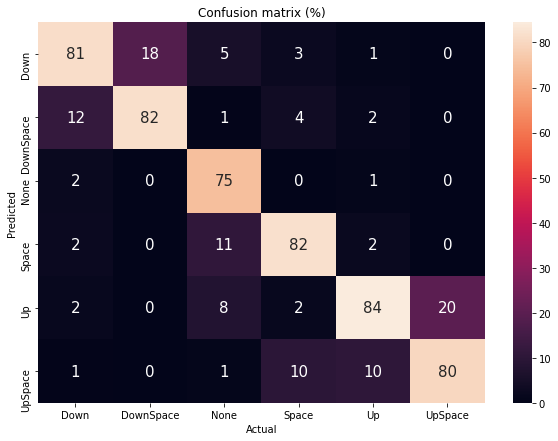

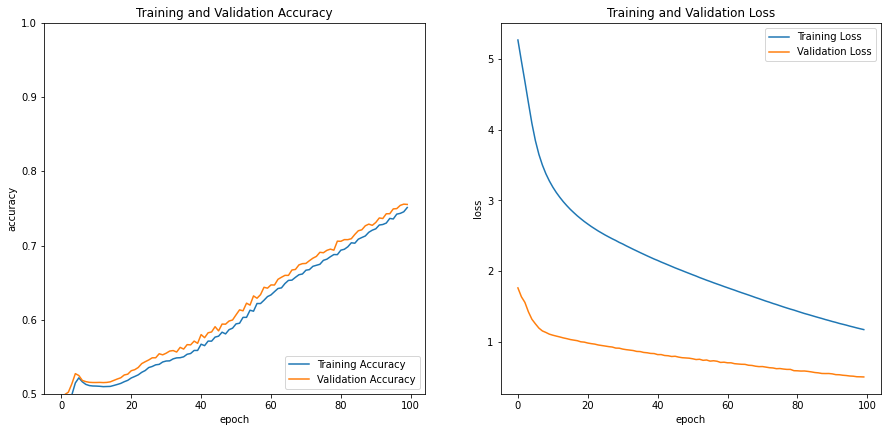

In [176]:
printGraphs(tmodels['4'], val_X, y_test, results['4'], 100)

In [177]:
tmodels['5'] = tf.keras.Sequential([  
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['5'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['5'] = tmodels['5'].fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=500,
               class_weight=weights)

Epoch 1/500
8/8 [==============================] - 1s 37ms/step - loss: 5.2693 - accuracy: 0.1360 - val_loss: 1.6727 - val_accuracy: 0.5119
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 4.9633 - accuracy: 0.5138 - val_loss: 1.5394 - val_accuracy: 0.5274
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 4.6642 - accuracy: 0.5235 - val_loss: 1.4194 - val_accuracy: 0.5264
Epoch 4/500
8/8 [==============================] - 0s 24ms/step - loss: 4.3588 - accuracy: 0.5160 - val_loss: 1.3236 - val_accuracy: 0.5175
Epoch 5/500
8/8 [==============================] - 0s 23ms/step - loss: 4.0701 - accuracy: 0.5121 - val_loss: 1.2568 - val_accuracy: 0.5153
Epoch 6/500
8/8 [==============================] - 0s 26ms/step - loss: 3.8340 - accuracy: 0.5104 - val_loss: 1.2159 - val_accuracy: 0.5151
Epoch 7/500
8/8 [==============================] - 0s 27ms/step - loss: 3.6545 - accuracy: 0.5107 - val_loss: 1.1766 - val_accuracy: 0.5155
Epoch 8/500
8/8 [===

8/8 [==============================] - 0s 24ms/step - loss: 1.6872 - accuracy: 0.6347 - val_loss: 0.6871 - val_accuracy: 0.6517
Epoch 60/500
8/8 [==============================] - 0s 25ms/step - loss: 1.6684 - accuracy: 0.6418 - val_loss: 0.6797 - val_accuracy: 0.6561
Epoch 61/500
8/8 [==============================] - 0s 23ms/step - loss: 1.6484 - accuracy: 0.6457 - val_loss: 0.6705 - val_accuracy: 0.6615
Epoch 62/500
8/8 [==============================] - 0s 23ms/step - loss: 1.6291 - accuracy: 0.6524 - val_loss: 0.6783 - val_accuracy: 0.6569
Epoch 63/500
8/8 [==============================] - 0s 24ms/step - loss: 1.6094 - accuracy: 0.6535 - val_loss: 0.6642 - val_accuracy: 0.6658
Epoch 64/500
8/8 [==============================] - 0s 25ms/step - loss: 1.5916 - accuracy: 0.6562 - val_loss: 0.6594 - val_accuracy: 0.6685
Epoch 65/500
8/8 [==============================] - 0s 25ms/step - loss: 1.5722 - accuracy: 0.6616 - val_loss: 0.6482 - val_accuracy: 0.6746
Epoch 66/500
8/8 [========

8/8 [==============================] - 0s 25ms/step - loss: 0.8842 - accuracy: 0.8271 - val_loss: 0.3878 - val_accuracy: 0.8323
Epoch 118/500
8/8 [==============================] - 0s 28ms/step - loss: 0.8758 - accuracy: 0.8287 - val_loss: 0.3864 - val_accuracy: 0.8356
Epoch 119/500
8/8 [==============================] - 0s 23ms/step - loss: 0.8670 - accuracy: 0.8328 - val_loss: 0.3882 - val_accuracy: 0.8314
Epoch 120/500
8/8 [==============================] - 0s 25ms/step - loss: 0.8596 - accuracy: 0.8314 - val_loss: 0.3825 - val_accuracy: 0.8381
Epoch 121/500
8/8 [==============================] - 0s 23ms/step - loss: 0.8514 - accuracy: 0.8347 - val_loss: 0.3819 - val_accuracy: 0.8362
Epoch 122/500
8/8 [==============================] - 0s 28ms/step - loss: 0.8436 - accuracy: 0.8360 - val_loss: 0.3811 - val_accuracy: 0.8377
Epoch 123/500
8/8 [==============================] - 0s 26ms/step - loss: 0.8379 - accuracy: 0.8370 - val_loss: 0.3711 - val_accuracy: 0.8434
Epoch 124/500
8/8 [=

Epoch 175/500
8/8 [==============================] - 0s 24ms/step - loss: 0.5704 - accuracy: 0.8899 - val_loss: 0.2748 - val_accuracy: 0.8935
Epoch 176/500
8/8 [==============================] - 0s 24ms/step - loss: 0.5653 - accuracy: 0.8919 - val_loss: 0.2788 - val_accuracy: 0.8912
Epoch 177/500
8/8 [==============================] - 0s 23ms/step - loss: 0.5623 - accuracy: 0.8925 - val_loss: 0.2807 - val_accuracy: 0.8898
Epoch 178/500
8/8 [==============================] - 0s 24ms/step - loss: 0.5584 - accuracy: 0.8911 - val_loss: 0.2723 - val_accuracy: 0.8945
Epoch 179/500
8/8 [==============================] - 0s 24ms/step - loss: 0.5551 - accuracy: 0.8927 - val_loss: 0.2715 - val_accuracy: 0.8948
Epoch 180/500
8/8 [==============================] - 0s 25ms/step - loss: 0.5521 - accuracy: 0.8938 - val_loss: 0.2679 - val_accuracy: 0.8967
Epoch 181/500
8/8 [==============================] - 0s 24ms/step - loss: 0.5489 - accuracy: 0.8947 - val_loss: 0.2643 - val_accuracy: 0.8975
Epoch 

Epoch 233/500
8/8 [==============================] - 0s 25ms/step - loss: 0.4067 - accuracy: 0.9224 - val_loss: 0.2116 - val_accuracy: 0.9220
Epoch 234/500
8/8 [==============================] - 0s 26ms/step - loss: 0.4048 - accuracy: 0.9224 - val_loss: 0.2086 - val_accuracy: 0.9230
Epoch 235/500
8/8 [==============================] - 0s 24ms/step - loss: 0.4024 - accuracy: 0.9226 - val_loss: 0.2111 - val_accuracy: 0.9212
Epoch 236/500
8/8 [==============================] - 0s 25ms/step - loss: 0.4015 - accuracy: 0.9229 - val_loss: 0.2138 - val_accuracy: 0.9194
Epoch 237/500
8/8 [==============================] - 0s 25ms/step - loss: 0.4002 - accuracy: 0.9218 - val_loss: 0.2086 - val_accuracy: 0.9215
Epoch 238/500
8/8 [==============================] - 0s 25ms/step - loss: 0.3985 - accuracy: 0.9224 - val_loss: 0.2061 - val_accuracy: 0.9232
Epoch 239/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3970 - accuracy: 0.9232 - val_loss: 0.2056 - val_accuracy: 0.9229
Epoch 

Epoch 291/500
8/8 [==============================] - 0s 23ms/step - loss: 0.3134 - accuracy: 0.9394 - val_loss: 0.1672 - val_accuracy: 0.9389
Epoch 292/500
8/8 [==============================] - 0s 23ms/step - loss: 0.3138 - accuracy: 0.9394 - val_loss: 0.1658 - val_accuracy: 0.9396
Epoch 293/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3127 - accuracy: 0.9396 - val_loss: 0.1625 - val_accuracy: 0.9417
Epoch 294/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3125 - accuracy: 0.9407 - val_loss: 0.1628 - val_accuracy: 0.9423
Epoch 295/500
8/8 [==============================] - 0s 25ms/step - loss: 0.3090 - accuracy: 0.9417 - val_loss: 0.1626 - val_accuracy: 0.9425
Epoch 296/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3062 - accuracy: 0.9422 - val_loss: 0.1631 - val_accuracy: 0.9429
Epoch 297/500
8/8 [==============================] - 0s 23ms/step - loss: 0.3030 - accuracy: 0.9428 - val_loss: 0.1648 - val_accuracy: 0.9421
Epoch 

Epoch 349/500
8/8 [==============================] - 0s 23ms/step - loss: 0.2565 - accuracy: 0.9502 - val_loss: 0.1353 - val_accuracy: 0.9530
Epoch 350/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2545 - accuracy: 0.9513 - val_loss: 0.1370 - val_accuracy: 0.9528
Epoch 351/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2535 - accuracy: 0.9516 - val_loss: 0.1384 - val_accuracy: 0.9526
Epoch 352/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2508 - accuracy: 0.9520 - val_loss: 0.1373 - val_accuracy: 0.9536
Epoch 353/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2485 - accuracy: 0.9527 - val_loss: 0.1384 - val_accuracy: 0.9532
Epoch 354/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2462 - accuracy: 0.9531 - val_loss: 0.1389 - val_accuracy: 0.9535
Epoch 355/500
8/8 [==============================] - 0s 28ms/step - loss: 0.2441 - accuracy: 0.9531 - val_loss: 0.1397 - val_accuracy: 0.9528
Epoch 

Epoch 407/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2086 - accuracy: 0.9582 - val_loss: 0.1232 - val_accuracy: 0.9589
Epoch 408/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2082 - accuracy: 0.9585 - val_loss: 0.1223 - val_accuracy: 0.9588
Epoch 409/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2075 - accuracy: 0.9582 - val_loss: 0.1219 - val_accuracy: 0.9583
Epoch 410/500
8/8 [==============================] - 0s 28ms/step - loss: 0.2077 - accuracy: 0.9579 - val_loss: 0.1214 - val_accuracy: 0.9581
Epoch 411/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2075 - accuracy: 0.9579 - val_loss: 0.1195 - val_accuracy: 0.9588
Epoch 412/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2078 - accuracy: 0.9582 - val_loss: 0.1188 - val_accuracy: 0.9588
Epoch 413/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2082 - accuracy: 0.9584 - val_loss: 0.1200 - val_accuracy: 0.9583
Epoch 

Epoch 465/500
8/8 [==============================] - 0s 25ms/step - loss: 0.1787 - accuracy: 0.9635 - val_loss: 0.1081 - val_accuracy: 0.9631
Epoch 466/500
8/8 [==============================] - 0s 27ms/step - loss: 0.1785 - accuracy: 0.9637 - val_loss: 0.1083 - val_accuracy: 0.9627
Epoch 467/500
8/8 [==============================] - 0s 24ms/step - loss: 0.1788 - accuracy: 0.9636 - val_loss: 0.1081 - val_accuracy: 0.9627
Epoch 468/500
8/8 [==============================] - 0s 23ms/step - loss: 0.1787 - accuracy: 0.9636 - val_loss: 0.1073 - val_accuracy: 0.9626
Epoch 469/500
8/8 [==============================] - 0s 26ms/step - loss: 0.1790 - accuracy: 0.9633 - val_loss: 0.1069 - val_accuracy: 0.9628
Epoch 470/500
8/8 [==============================] - 0s 24ms/step - loss: 0.1791 - accuracy: 0.9637 - val_loss: 0.1064 - val_accuracy: 0.9630
Epoch 471/500
8/8 [==============================] - 0s 27ms/step - loss: 0.1791 - accuracy: 0.9636 - val_loss: 0.1085 - val_accuracy: 0.9622
Epoch 

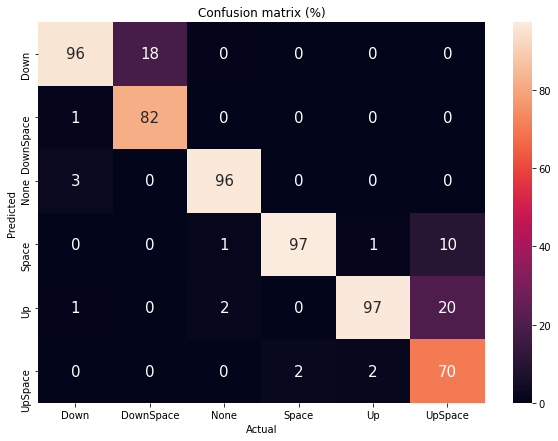

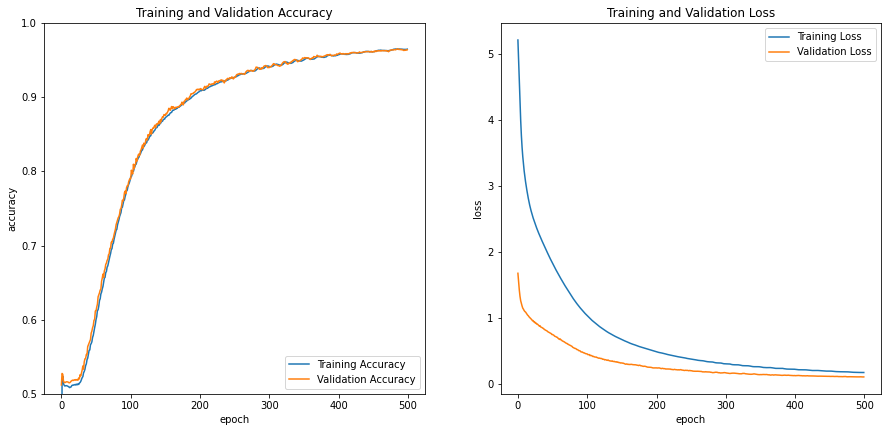

In [179]:
printGraphs(tmodels['5'], val_X, y_test, results['5'], 500)

In [181]:
tmodels['6'] = tf.keras.Sequential([  
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['6'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['6'] = tmodels['6'].fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=500,
               class_weight=weights)

Epoch 1/500
8/8 [==============================] - 1s 43ms/step - loss: 5.3420 - accuracy: 0.2183 - val_loss: 1.6677 - val_accuracy: 0.4698
Epoch 2/500
8/8 [==============================] - 0s 31ms/step - loss: 5.0214 - accuracy: 0.4731 - val_loss: 1.4997 - val_accuracy: 0.4945
Epoch 3/500
8/8 [==============================] - 0s 35ms/step - loss: 4.6286 - accuracy: 0.4858 - val_loss: 1.3343 - val_accuracy: 0.4920
Epoch 4/500
8/8 [==============================] - 0s 34ms/step - loss: 4.1521 - accuracy: 0.4839 - val_loss: 1.2051 - val_accuracy: 0.5020
Epoch 5/500
8/8 [==============================] - 0s 33ms/step - loss: 3.7420 - accuracy: 0.4964 - val_loss: 1.1508 - val_accuracy: 0.5147
Epoch 6/500
8/8 [==============================] - 0s 34ms/step - loss: 3.4710 - accuracy: 0.5086 - val_loss: 1.1147 - val_accuracy: 0.5158
Epoch 7/500
8/8 [==============================] - 0s 33ms/step - loss: 3.2910 - accuracy: 0.5082 - val_loss: 1.1030 - val_accuracy: 0.5131
Epoch 8/500
8/8 [===

8/8 [==============================] - 0s 33ms/step - loss: 1.0057 - accuracy: 0.7912 - val_loss: 0.4468 - val_accuracy: 0.7922
Epoch 60/500
8/8 [==============================] - 0s 33ms/step - loss: 0.9790 - accuracy: 0.7954 - val_loss: 0.4367 - val_accuracy: 0.7977
Epoch 61/500
8/8 [==============================] - 0s 33ms/step - loss: 0.9540 - accuracy: 0.8004 - val_loss: 0.4231 - val_accuracy: 0.8062
Epoch 62/500
8/8 [==============================] - 0s 34ms/step - loss: 0.9325 - accuracy: 0.8066 - val_loss: 0.4104 - val_accuracy: 0.8117
Epoch 63/500
8/8 [==============================] - 0s 33ms/step - loss: 0.9074 - accuracy: 0.8132 - val_loss: 0.3991 - val_accuracy: 0.8217
Epoch 64/500
8/8 [==============================] - 0s 36ms/step - loss: 0.8875 - accuracy: 0.8195 - val_loss: 0.3922 - val_accuracy: 0.8211
Epoch 65/500
8/8 [==============================] - 0s 32ms/step - loss: 0.8687 - accuracy: 0.8222 - val_loss: 0.3745 - val_accuracy: 0.8328
Epoch 66/500
8/8 [========

8/8 [==============================] - 0s 33ms/step - loss: 0.3817 - accuracy: 0.9209 - val_loss: 0.1935 - val_accuracy: 0.9312
Epoch 118/500
8/8 [==============================] - 0s 34ms/step - loss: 0.3774 - accuracy: 0.9229 - val_loss: 0.1979 - val_accuracy: 0.9293
Epoch 119/500
8/8 [==============================] - 0s 31ms/step - loss: 0.3743 - accuracy: 0.9230 - val_loss: 0.1908 - val_accuracy: 0.9323
Epoch 120/500
8/8 [==============================] - 0s 34ms/step - loss: 0.3691 - accuracy: 0.9244 - val_loss: 0.1944 - val_accuracy: 0.9302
Epoch 121/500
8/8 [==============================] - 0s 31ms/step - loss: 0.3636 - accuracy: 0.9245 - val_loss: 0.1898 - val_accuracy: 0.9327
Epoch 122/500
8/8 [==============================] - 0s 32ms/step - loss: 0.3585 - accuracy: 0.9253 - val_loss: 0.1880 - val_accuracy: 0.9325
Epoch 123/500
8/8 [==============================] - 0s 34ms/step - loss: 0.3549 - accuracy: 0.9266 - val_loss: 0.1843 - val_accuracy: 0.9349
Epoch 124/500
8/8 [=

Epoch 175/500
8/8 [==============================] - 0s 36ms/step - loss: 0.2191 - accuracy: 0.9542 - val_loss: 0.1285 - val_accuracy: 0.9566
Epoch 176/500
8/8 [==============================] - 0s 35ms/step - loss: 0.2167 - accuracy: 0.9542 - val_loss: 0.1283 - val_accuracy: 0.9572
Epoch 177/500
8/8 [==============================] - 0s 34ms/step - loss: 0.2156 - accuracy: 0.9545 - val_loss: 0.1292 - val_accuracy: 0.9564
Epoch 178/500
8/8 [==============================] - 0s 34ms/step - loss: 0.2139 - accuracy: 0.9547 - val_loss: 0.1278 - val_accuracy: 0.9570
Epoch 179/500
8/8 [==============================] - 0s 34ms/step - loss: 0.2125 - accuracy: 0.9546 - val_loss: 0.1264 - val_accuracy: 0.9572
Epoch 180/500
8/8 [==============================] - 0s 34ms/step - loss: 0.2111 - accuracy: 0.9551 - val_loss: 0.1252 - val_accuracy: 0.9580
Epoch 181/500
8/8 [==============================] - 0s 31ms/step - loss: 0.2096 - accuracy: 0.9555 - val_loss: 0.1260 - val_accuracy: 0.9579
Epoch 

Epoch 233/500
8/8 [==============================] - 0s 32ms/step - loss: 0.1567 - accuracy: 0.9656 - val_loss: 0.0913 - val_accuracy: 0.9696
Epoch 234/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1584 - accuracy: 0.9653 - val_loss: 0.0944 - val_accuracy: 0.9691
Epoch 235/500
8/8 [==============================] - 0s 35ms/step - loss: 0.1561 - accuracy: 0.9652 - val_loss: 0.0941 - val_accuracy: 0.9687
Epoch 236/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1551 - accuracy: 0.9662 - val_loss: 0.0915 - val_accuracy: 0.9712
Epoch 237/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1532 - accuracy: 0.9663 - val_loss: 0.0906 - val_accuracy: 0.9708
Epoch 238/500
8/8 [==============================] - 0s 33ms/step - loss: 0.1522 - accuracy: 0.9668 - val_loss: 0.0910 - val_accuracy: 0.9706
Epoch 239/500
8/8 [==============================] - 0s 32ms/step - loss: 0.1562 - accuracy: 0.9666 - val_loss: 0.0880 - val_accuracy: 0.9704
Epoch 

Epoch 291/500
8/8 [==============================] - 0s 33ms/step - loss: 0.1189 - accuracy: 0.9723 - val_loss: 0.0843 - val_accuracy: 0.9730
Epoch 292/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1176 - accuracy: 0.9728 - val_loss: 0.0831 - val_accuracy: 0.9735
Epoch 293/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1174 - accuracy: 0.9727 - val_loss: 0.0836 - val_accuracy: 0.9730
Epoch 294/500
8/8 [==============================] - 0s 36ms/step - loss: 0.1164 - accuracy: 0.9728 - val_loss: 0.0830 - val_accuracy: 0.9732
Epoch 295/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1159 - accuracy: 0.9730 - val_loss: 0.0820 - val_accuracy: 0.9739
Epoch 296/500
8/8 [==============================] - 0s 54ms/step - loss: 0.1151 - accuracy: 0.9728 - val_loss: 0.0819 - val_accuracy: 0.9734
Epoch 297/500
8/8 [==============================] - 0s 36ms/step - loss: 0.1150 - accuracy: 0.9733 - val_loss: 0.0808 - val_accuracy: 0.9744
Epoch 

Epoch 349/500
8/8 [==============================] - 0s 32ms/step - loss: 0.0937 - accuracy: 0.9774 - val_loss: 0.0682 - val_accuracy: 0.9782
Epoch 350/500
8/8 [==============================] - 0s 34ms/step - loss: 0.0936 - accuracy: 0.9771 - val_loss: 0.0680 - val_accuracy: 0.9775
Epoch 351/500
8/8 [==============================] - 0s 32ms/step - loss: 0.0936 - accuracy: 0.9773 - val_loss: 0.0668 - val_accuracy: 0.9787
Epoch 352/500
8/8 [==============================] - 0s 33ms/step - loss: 0.0927 - accuracy: 0.9776 - val_loss: 0.0663 - val_accuracy: 0.9787
Epoch 353/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0925 - accuracy: 0.9776 - val_loss: 0.0667 - val_accuracy: 0.9781
Epoch 354/500
8/8 [==============================] - 0s 36ms/step - loss: 0.0932 - accuracy: 0.9773 - val_loss: 0.0660 - val_accuracy: 0.9784
Epoch 355/500
8/8 [==============================] - 0s 33ms/step - loss: 0.0920 - accuracy: 0.9778 - val_loss: 0.0666 - val_accuracy: 0.9786
Epoch 

Epoch 407/500
8/8 [==============================] - 0s 34ms/step - loss: 0.2510 - accuracy: 0.9395 - val_loss: 0.1153 - val_accuracy: 0.9597
Epoch 408/500
8/8 [==============================] - 0s 35ms/step - loss: 0.1870 - accuracy: 0.9631 - val_loss: 0.0936 - val_accuracy: 0.9702
Epoch 409/500
8/8 [==============================] - 0s 37ms/step - loss: 0.1535 - accuracy: 0.9675 - val_loss: 0.0967 - val_accuracy: 0.9655
Epoch 410/500
8/8 [==============================] - 0s 33ms/step - loss: 0.1410 - accuracy: 0.9665 - val_loss: 0.0794 - val_accuracy: 0.9732
Epoch 411/500
8/8 [==============================] - 0s 35ms/step - loss: 0.1297 - accuracy: 0.9705 - val_loss: 0.0824 - val_accuracy: 0.9716
Epoch 412/500
8/8 [==============================] - 0s 35ms/step - loss: 0.1244 - accuracy: 0.9715 - val_loss: 0.0762 - val_accuracy: 0.9743
Epoch 413/500
8/8 [==============================] - 0s 34ms/step - loss: 0.1205 - accuracy: 0.9735 - val_loss: 0.0826 - val_accuracy: 0.9714
Epoch 

Epoch 465/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0732 - accuracy: 0.9807 - val_loss: 0.0586 - val_accuracy: 0.9804
Epoch 466/500
8/8 [==============================] - 0s 34ms/step - loss: 0.0730 - accuracy: 0.9807 - val_loss: 0.0588 - val_accuracy: 0.9801
Epoch 467/500
8/8 [==============================] - 0s 33ms/step - loss: 0.0727 - accuracy: 0.9807 - val_loss: 0.0582 - val_accuracy: 0.9806
Epoch 468/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0722 - accuracy: 0.9809 - val_loss: 0.0584 - val_accuracy: 0.9805
Epoch 469/500
8/8 [==============================] - 0s 35ms/step - loss: 0.0719 - accuracy: 0.9809 - val_loss: 0.0587 - val_accuracy: 0.9801
Epoch 470/500
8/8 [==============================] - 0s 32ms/step - loss: 0.0718 - accuracy: 0.9809 - val_loss: 0.0583 - val_accuracy: 0.9804
Epoch 471/500
8/8 [==============================] - 0s 32ms/step - loss: 0.0714 - accuracy: 0.9807 - val_loss: 0.0575 - val_accuracy: 0.9808
Epoch 

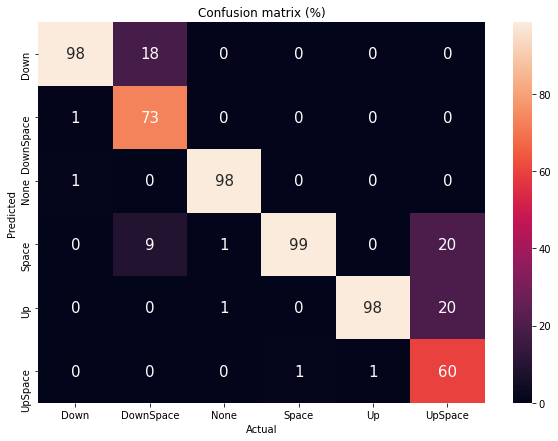

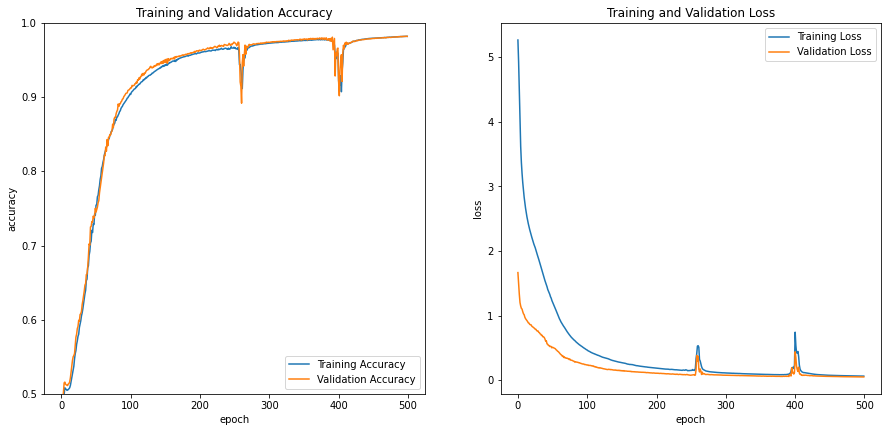

In [182]:
printGraphs(tmodels['6'], val_X, y_test, results['6'], 500)

In [186]:
tmodels['7'] = tf.keras.Sequential([  
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['7'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['7'] = tmodels['7'].fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=500,
               class_weight=weights)

Epoch 1/500
8/8 [==============================] - 0s 25ms/step - loss: 5.3441 - accuracy: 0.6407 - val_loss: 1.6771 - val_accuracy: 0.5569
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 5.1943 - accuracy: 0.5351 - val_loss: 1.6867 - val_accuracy: 0.4691
Epoch 3/500
8/8 [==============================] - 0s 13ms/step - loss: 5.0668 - accuracy: 0.4558 - val_loss: 1.6528 - val_accuracy: 0.4664
Epoch 4/500
8/8 [==============================] - 0s 12ms/step - loss: 4.9430 - accuracy: 0.4654 - val_loss: 1.5887 - val_accuracy: 0.4827
Epoch 5/500
8/8 [==============================] - 0s 12ms/step - loss: 4.8183 - accuracy: 0.4841 - val_loss: 1.5196 - val_accuracy: 0.5025
Epoch 6/500
8/8 [==============================] - 0s 13ms/step - loss: 4.6961 - accuracy: 0.4996 - val_loss: 1.4666 - val_accuracy: 0.5069
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 4.5797 - accuracy: 0.5028 - val_loss: 1.4305 - val_accuracy: 0.5072
Epoch 8/500
8/8 [===

8/8 [==============================] - 0s 16ms/step - loss: 2.7763 - accuracy: 0.5131 - val_loss: 1.0132 - val_accuracy: 0.5184
Epoch 60/500
8/8 [==============================] - 0s 13ms/step - loss: 2.7637 - accuracy: 0.5133 - val_loss: 1.0098 - val_accuracy: 0.5185
Epoch 61/500
8/8 [==============================] - 0s 15ms/step - loss: 2.7513 - accuracy: 0.5133 - val_loss: 1.0057 - val_accuracy: 0.5186
Epoch 62/500
8/8 [==============================] - 0s 13ms/step - loss: 2.7387 - accuracy: 0.5134 - val_loss: 1.0020 - val_accuracy: 0.5188
Epoch 63/500
8/8 [==============================] - 0s 12ms/step - loss: 2.7267 - accuracy: 0.5135 - val_loss: 0.9981 - val_accuracy: 0.5189
Epoch 64/500
8/8 [==============================] - 0s 12ms/step - loss: 2.7148 - accuracy: 0.5133 - val_loss: 0.9959 - val_accuracy: 0.5186
Epoch 65/500
8/8 [==============================] - 0s 13ms/step - loss: 2.7027 - accuracy: 0.5133 - val_loss: 0.9908 - val_accuracy: 0.5187
Epoch 66/500
8/8 [========

8/8 [==============================] - 0s 12ms/step - loss: 2.2364 - accuracy: 0.5501 - val_loss: 0.8500 - val_accuracy: 0.5556
Epoch 118/500
8/8 [==============================] - 0s 14ms/step - loss: 2.2289 - accuracy: 0.5522 - val_loss: 0.8479 - val_accuracy: 0.5571
Epoch 119/500
8/8 [==============================] - 0s 12ms/step - loss: 2.2213 - accuracy: 0.5538 - val_loss: 0.8466 - val_accuracy: 0.5579
Epoch 120/500
8/8 [==============================] - 0s 13ms/step - loss: 2.2141 - accuracy: 0.5548 - val_loss: 0.8450 - val_accuracy: 0.5597
Epoch 121/500
8/8 [==============================] - 0s 12ms/step - loss: 2.2067 - accuracy: 0.5567 - val_loss: 0.8405 - val_accuracy: 0.5615
Epoch 122/500
8/8 [==============================] - 0s 12ms/step - loss: 2.1996 - accuracy: 0.5584 - val_loss: 0.8390 - val_accuracy: 0.5626
Epoch 123/500
8/8 [==============================] - 0s 14ms/step - loss: 2.1925 - accuracy: 0.5592 - val_loss: 0.8388 - val_accuracy: 0.5637
Epoch 124/500
8/8 [=

Epoch 175/500
8/8 [==============================] - 0s 13ms/step - loss: 1.8649 - accuracy: 0.6256 - val_loss: 0.7330 - val_accuracy: 0.6301
Epoch 176/500
8/8 [==============================] - 0s 12ms/step - loss: 1.8594 - accuracy: 0.6274 - val_loss: 0.7352 - val_accuracy: 0.6285
Epoch 177/500
8/8 [==============================] - 0s 14ms/step - loss: 1.8539 - accuracy: 0.6275 - val_loss: 0.7318 - val_accuracy: 0.6308
Epoch 178/500
8/8 [==============================] - 0s 13ms/step - loss: 1.8484 - accuracy: 0.6287 - val_loss: 0.7326 - val_accuracy: 0.6302
Epoch 179/500
8/8 [==============================] - 0s 12ms/step - loss: 1.8425 - accuracy: 0.6293 - val_loss: 0.7281 - val_accuracy: 0.6330
Epoch 180/500
8/8 [==============================] - 0s 12ms/step - loss: 1.8374 - accuracy: 0.6307 - val_loss: 0.7278 - val_accuracy: 0.6330
Epoch 181/500
8/8 [==============================] - 0s 13ms/step - loss: 1.8316 - accuracy: 0.6318 - val_loss: 0.7265 - val_accuracy: 0.6332
Epoch 

Epoch 233/500
8/8 [==============================] - 0s 13ms/step - loss: 1.5777 - accuracy: 0.6711 - val_loss: 0.6473 - val_accuracy: 0.6745
Epoch 234/500
8/8 [==============================] - 0s 12ms/step - loss: 1.5725 - accuracy: 0.6728 - val_loss: 0.6469 - val_accuracy: 0.6743
Epoch 235/500
8/8 [==============================] - 0s 13ms/step - loss: 1.5684 - accuracy: 0.6729 - val_loss: 0.6448 - val_accuracy: 0.6756
Epoch 236/500
8/8 [==============================] - 0s 13ms/step - loss: 1.5643 - accuracy: 0.6739 - val_loss: 0.6446 - val_accuracy: 0.6751
Epoch 237/500
8/8 [==============================] - 0s 12ms/step - loss: 1.5597 - accuracy: 0.6735 - val_loss: 0.6436 - val_accuracy: 0.6757
Epoch 238/500
8/8 [==============================] - 0s 12ms/step - loss: 1.5556 - accuracy: 0.6747 - val_loss: 0.6417 - val_accuracy: 0.6769
Epoch 239/500
8/8 [==============================] - 0s 12ms/step - loss: 1.5516 - accuracy: 0.6754 - val_loss: 0.6386 - val_accuracy: 0.6782
Epoch 

Epoch 291/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3547 - accuracy: 0.7106 - val_loss: 0.5774 - val_accuracy: 0.7117
Epoch 292/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3513 - accuracy: 0.7102 - val_loss: 0.5768 - val_accuracy: 0.7126
Epoch 293/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3482 - accuracy: 0.7120 - val_loss: 0.5737 - val_accuracy: 0.7138
Epoch 294/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3450 - accuracy: 0.7119 - val_loss: 0.5754 - val_accuracy: 0.7127
Epoch 295/500
8/8 [==============================] - 0s 14ms/step - loss: 1.3411 - accuracy: 0.7119 - val_loss: 0.5722 - val_accuracy: 0.7146
Epoch 296/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3379 - accuracy: 0.7134 - val_loss: 0.5728 - val_accuracy: 0.7146
Epoch 297/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3348 - accuracy: 0.7137 - val_loss: 0.5692 - val_accuracy: 0.7165
Epoch 

Epoch 349/500
8/8 [==============================] - 0s 13ms/step - loss: 1.1827 - accuracy: 0.7451 - val_loss: 0.5197 - val_accuracy: 0.7455
Epoch 350/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1804 - accuracy: 0.7452 - val_loss: 0.5189 - val_accuracy: 0.7461
Epoch 351/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1778 - accuracy: 0.7462 - val_loss: 0.5175 - val_accuracy: 0.7470
Epoch 352/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1752 - accuracy: 0.7468 - val_loss: 0.5169 - val_accuracy: 0.7473
Epoch 353/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1726 - accuracy: 0.7469 - val_loss: 0.5147 - val_accuracy: 0.7482
Epoch 354/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1704 - accuracy: 0.7478 - val_loss: 0.5144 - val_accuracy: 0.7493
Epoch 355/500
8/8 [==============================] - 0s 12ms/step - loss: 1.1674 - accuracy: 0.7488 - val_loss: 0.5146 - val_accuracy: 0.7484
Epoch 

Epoch 407/500
8/8 [==============================] - 0s 16ms/step - loss: 1.0489 - accuracy: 0.7734 - val_loss: 0.4704 - val_accuracy: 0.7758
Epoch 408/500
8/8 [==============================] - 0s 15ms/step - loss: 1.0468 - accuracy: 0.7747 - val_loss: 0.4736 - val_accuracy: 0.7743
Epoch 409/500
8/8 [==============================] - 0s 15ms/step - loss: 1.0445 - accuracy: 0.7747 - val_loss: 0.4706 - val_accuracy: 0.7754
Epoch 410/500
8/8 [==============================] - 0s 15ms/step - loss: 1.0429 - accuracy: 0.7744 - val_loss: 0.4726 - val_accuracy: 0.7746
Epoch 411/500
8/8 [==============================] - 0s 12ms/step - loss: 1.0405 - accuracy: 0.7754 - val_loss: 0.4684 - val_accuracy: 0.7774
Epoch 412/500
8/8 [==============================] - 0s 12ms/step - loss: 1.0384 - accuracy: 0.7760 - val_loss: 0.4718 - val_accuracy: 0.7748
Epoch 413/500
8/8 [==============================] - 0s 12ms/step - loss: 1.0365 - accuracy: 0.7758 - val_loss: 0.4651 - val_accuracy: 0.7790
Epoch 

Epoch 465/500
8/8 [==============================] - 0s 16ms/step - loss: 0.9427 - accuracy: 0.7990 - val_loss: 0.4348 - val_accuracy: 0.7987
Epoch 466/500
8/8 [==============================] - 0s 16ms/step - loss: 0.9412 - accuracy: 0.7994 - val_loss: 0.4362 - val_accuracy: 0.7986
Epoch 467/500
8/8 [==============================] - 0s 15ms/step - loss: 0.9394 - accuracy: 0.8002 - val_loss: 0.4341 - val_accuracy: 0.8000
Epoch 468/500
8/8 [==============================] - 0s 14ms/step - loss: 0.9376 - accuracy: 0.8002 - val_loss: 0.4348 - val_accuracy: 0.7992
Epoch 469/500
8/8 [==============================] - 0s 16ms/step - loss: 0.9361 - accuracy: 0.8010 - val_loss: 0.4323 - val_accuracy: 0.7999
Epoch 470/500
8/8 [==============================] - 0s 22ms/step - loss: 0.9346 - accuracy: 0.8007 - val_loss: 0.4353 - val_accuracy: 0.7987
Epoch 471/500
8/8 [==============================] - 0s 15ms/step - loss: 0.9328 - accuracy: 0.8010 - val_loss: 0.4293 - val_accuracy: 0.8034
Epoch 

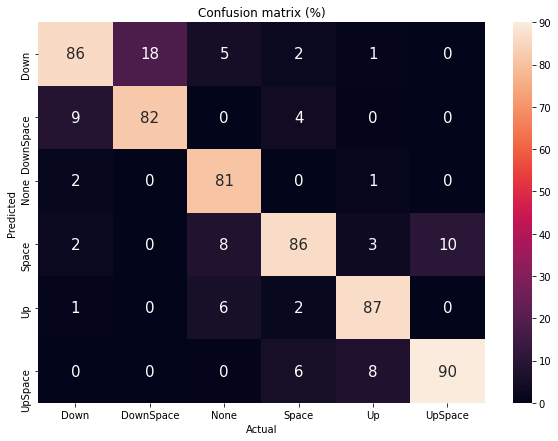

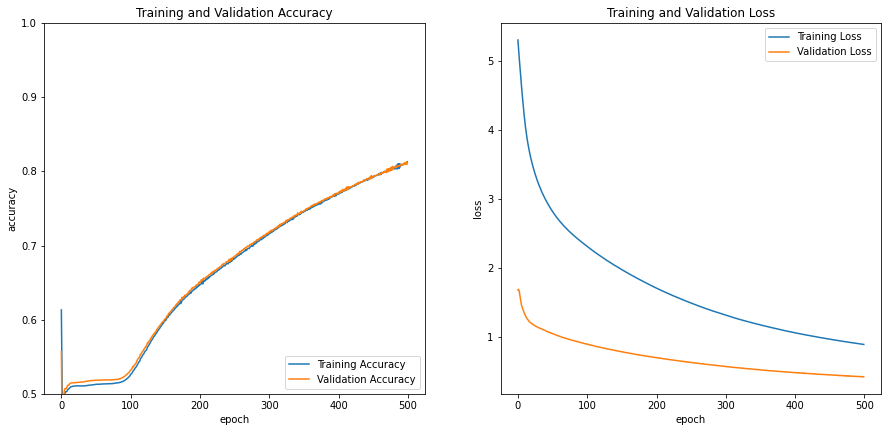

In [187]:
printGraphs(tmodels['7'], val_X, y_test, results['7'], 500)

In [183]:
tmodels['8'] = tf.keras.Sequential([  
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['8'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['8'] = tmodels['8'].fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=500,
               class_weight=weights)

Epoch 1/500
8/8 [==============================] - 1s 65ms/step - loss: 5.2329 - accuracy: 0.1334 - val_loss: 1.6341 - val_accuracy: 0.4887
Epoch 2/500
8/8 [==============================] - 0s 58ms/step - loss: 4.7205 - accuracy: 0.4765 - val_loss: 1.4976 - val_accuracy: 0.4827
Epoch 3/500
8/8 [==============================] - 0s 56ms/step - loss: 4.2598 - accuracy: 0.4776 - val_loss: 1.3404 - val_accuracy: 0.4932
Epoch 4/500
8/8 [==============================] - 0s 54ms/step - loss: 3.8817 - accuracy: 0.4917 - val_loss: 1.2343 - val_accuracy: 0.5131
Epoch 5/500
8/8 [==============================] - 0s 55ms/step - loss: 3.6315 - accuracy: 0.5083 - val_loss: 1.1888 - val_accuracy: 0.5142
Epoch 6/500
8/8 [==============================] - 0s 54ms/step - loss: 3.4453 - accuracy: 0.5089 - val_loss: 1.1452 - val_accuracy: 0.5140
Epoch 7/500
8/8 [==============================] - 0s 55ms/step - loss: 3.3045 - accuracy: 0.5087 - val_loss: 1.1157 - val_accuracy: 0.5141
Epoch 8/500
8/8 [===

8/8 [==============================] - 0s 53ms/step - loss: 1.2193 - accuracy: 0.7476 - val_loss: 0.5221 - val_accuracy: 0.7532
Epoch 60/500
8/8 [==============================] - 0s 52ms/step - loss: 1.1972 - accuracy: 0.7519 - val_loss: 0.5088 - val_accuracy: 0.7608
Epoch 61/500
8/8 [==============================] - 0s 54ms/step - loss: 1.1757 - accuracy: 0.7600 - val_loss: 0.5083 - val_accuracy: 0.7615
Epoch 62/500
8/8 [==============================] - 0s 53ms/step - loss: 1.1592 - accuracy: 0.7633 - val_loss: 0.5054 - val_accuracy: 0.7628
Epoch 63/500
8/8 [==============================] - 0s 52ms/step - loss: 1.1406 - accuracy: 0.7655 - val_loss: 0.4990 - val_accuracy: 0.7670
Epoch 64/500
8/8 [==============================] - 0s 54ms/step - loss: 1.1218 - accuracy: 0.7691 - val_loss: 0.4893 - val_accuracy: 0.7727
Epoch 65/500
8/8 [==============================] - 0s 52ms/step - loss: 1.1046 - accuracy: 0.7748 - val_loss: 0.4862 - val_accuracy: 0.7748
Epoch 66/500
8/8 [========

8/8 [==============================] - 0s 56ms/step - loss: 0.5753 - accuracy: 0.8859 - val_loss: 0.2874 - val_accuracy: 0.8837
Epoch 118/500
8/8 [==============================] - 0s 52ms/step - loss: 0.5683 - accuracy: 0.8881 - val_loss: 0.2865 - val_accuracy: 0.8853
Epoch 119/500
8/8 [==============================] - 0s 52ms/step - loss: 0.5622 - accuracy: 0.8896 - val_loss: 0.2858 - val_accuracy: 0.8854
Epoch 120/500
8/8 [==============================] - 0s 55ms/step - loss: 0.5556 - accuracy: 0.8908 - val_loss: 0.2841 - val_accuracy: 0.8867
Epoch 121/500
8/8 [==============================] - 0s 55ms/step - loss: 0.5485 - accuracy: 0.8919 - val_loss: 0.2836 - val_accuracy: 0.8867
Epoch 122/500
8/8 [==============================] - 0s 53ms/step - loss: 0.5440 - accuracy: 0.8925 - val_loss: 0.2840 - val_accuracy: 0.8859
Epoch 123/500
8/8 [==============================] - 0s 52ms/step - loss: 0.5382 - accuracy: 0.8922 - val_loss: 0.2814 - val_accuracy: 0.8862
Epoch 124/500
8/8 [=

Epoch 175/500
8/8 [==============================] - 0s 53ms/step - loss: 0.3676 - accuracy: 0.9269 - val_loss: 0.2075 - val_accuracy: 0.9234
Epoch 176/500
8/8 [==============================] - 0s 54ms/step - loss: 0.3649 - accuracy: 0.9271 - val_loss: 0.2066 - val_accuracy: 0.9230
Epoch 177/500
8/8 [==============================] - 0s 55ms/step - loss: 0.3635 - accuracy: 0.9271 - val_loss: 0.2057 - val_accuracy: 0.9226
Epoch 178/500
8/8 [==============================] - 0s 56ms/step - loss: 0.3613 - accuracy: 0.9271 - val_loss: 0.2034 - val_accuracy: 0.9238
Epoch 179/500
8/8 [==============================] - 0s 54ms/step - loss: 0.3594 - accuracy: 0.9275 - val_loss: 0.2026 - val_accuracy: 0.9230
Epoch 180/500
8/8 [==============================] - 0s 52ms/step - loss: 0.3574 - accuracy: 0.9272 - val_loss: 0.2005 - val_accuracy: 0.9240
Epoch 181/500
8/8 [==============================] - 0s 63ms/step - loss: 0.3553 - accuracy: 0.9277 - val_loss: 0.2014 - val_accuracy: 0.9233
Epoch 

Epoch 233/500
8/8 [==============================] - 0s 57ms/step - loss: 0.2721 - accuracy: 0.9463 - val_loss: 0.1605 - val_accuracy: 0.9442
Epoch 234/500
8/8 [==============================] - 0s 55ms/step - loss: 0.2699 - accuracy: 0.9466 - val_loss: 0.1594 - val_accuracy: 0.9446
Epoch 235/500
8/8 [==============================] - 0s 55ms/step - loss: 0.2682 - accuracy: 0.9472 - val_loss: 0.1597 - val_accuracy: 0.9446
Epoch 236/500
8/8 [==============================] - 0s 54ms/step - loss: 0.2673 - accuracy: 0.9473 - val_loss: 0.1602 - val_accuracy: 0.9448
Epoch 237/500
8/8 [==============================] - 0s 56ms/step - loss: 0.2652 - accuracy: 0.9477 - val_loss: 0.1592 - val_accuracy: 0.9458
Epoch 238/500
8/8 [==============================] - 0s 55ms/step - loss: 0.2631 - accuracy: 0.9481 - val_loss: 0.1585 - val_accuracy: 0.9458
Epoch 239/500
8/8 [==============================] - 0s 55ms/step - loss: 0.2614 - accuracy: 0.9485 - val_loss: 0.1583 - val_accuracy: 0.9460
Epoch 

Epoch 291/500
8/8 [==============================] - 0s 55ms/step - loss: 0.2109 - accuracy: 0.9562 - val_loss: 0.1336 - val_accuracy: 0.9549
Epoch 292/500
8/8 [==============================] - 0s 53ms/step - loss: 0.2094 - accuracy: 0.9564 - val_loss: 0.1329 - val_accuracy: 0.9554
Epoch 293/500
8/8 [==============================] - 0s 54ms/step - loss: 0.2089 - accuracy: 0.9566 - val_loss: 0.1339 - val_accuracy: 0.9553
Epoch 294/500
8/8 [==============================] - 0s 57ms/step - loss: 0.2077 - accuracy: 0.9566 - val_loss: 0.1320 - val_accuracy: 0.9557
Epoch 295/500
8/8 [==============================] - 0s 52ms/step - loss: 0.2076 - accuracy: 0.9567 - val_loss: 0.1316 - val_accuracy: 0.9556
Epoch 296/500
8/8 [==============================] - 0s 58ms/step - loss: 0.2074 - accuracy: 0.9572 - val_loss: 0.1315 - val_accuracy: 0.9555
Epoch 297/500
8/8 [==============================] - 0s 53ms/step - loss: 0.2057 - accuracy: 0.9570 - val_loss: 0.1308 - val_accuracy: 0.9563
Epoch 

Epoch 349/500
8/8 [==============================] - 0s 53ms/step - loss: 0.1819 - accuracy: 0.9644 - val_loss: 0.1091 - val_accuracy: 0.9654
Epoch 350/500
8/8 [==============================] - 0s 55ms/step - loss: 0.1813 - accuracy: 0.9649 - val_loss: 0.1099 - val_accuracy: 0.9651
Epoch 351/500
8/8 [==============================] - 0s 53ms/step - loss: 0.1798 - accuracy: 0.9654 - val_loss: 0.1135 - val_accuracy: 0.9646
Epoch 352/500
8/8 [==============================] - 0s 55ms/step - loss: 0.1780 - accuracy: 0.9651 - val_loss: 0.1125 - val_accuracy: 0.9649
Epoch 353/500
8/8 [==============================] - 0s 54ms/step - loss: 0.1773 - accuracy: 0.9652 - val_loss: 0.1108 - val_accuracy: 0.9647
Epoch 354/500
8/8 [==============================] - 0s 55ms/step - loss: 0.1769 - accuracy: 0.9658 - val_loss: 0.1146 - val_accuracy: 0.9635
Epoch 355/500
8/8 [==============================] - 0s 53ms/step - loss: 0.1751 - accuracy: 0.9655 - val_loss: 0.1163 - val_accuracy: 0.9628
Epoch 

Epoch 407/500
8/8 [==============================] - 0s 58ms/step - loss: 0.1375 - accuracy: 0.9706 - val_loss: 0.1008 - val_accuracy: 0.9677
Epoch 408/500
8/8 [==============================] - 0s 53ms/step - loss: 0.1371 - accuracy: 0.9707 - val_loss: 0.1008 - val_accuracy: 0.9677
Epoch 409/500
8/8 [==============================] - 0s 56ms/step - loss: 0.1364 - accuracy: 0.9709 - val_loss: 0.0995 - val_accuracy: 0.9683
Epoch 410/500
8/8 [==============================] - 0s 59ms/step - loss: 0.1364 - accuracy: 0.9711 - val_loss: 0.0996 - val_accuracy: 0.9682
Epoch 411/500
8/8 [==============================] - 0s 56ms/step - loss: 0.1357 - accuracy: 0.9711 - val_loss: 0.0997 - val_accuracy: 0.9684
Epoch 412/500
8/8 [==============================] - 0s 57ms/step - loss: 0.1353 - accuracy: 0.9713 - val_loss: 0.0986 - val_accuracy: 0.9686
Epoch 413/500
8/8 [==============================] - 0s 56ms/step - loss: 0.1347 - accuracy: 0.9712 - val_loss: 0.0987 - val_accuracy: 0.9685
Epoch 

Epoch 465/500
8/8 [==============================] - 0s 55ms/step - loss: 0.1158 - accuracy: 0.9744 - val_loss: 0.0877 - val_accuracy: 0.9722
Epoch 466/500
8/8 [==============================] - 0s 53ms/step - loss: 0.1158 - accuracy: 0.9748 - val_loss: 0.0874 - val_accuracy: 0.9728
Epoch 467/500
8/8 [==============================] - 0s 57ms/step - loss: 0.1154 - accuracy: 0.9746 - val_loss: 0.0871 - val_accuracy: 0.9726
Epoch 468/500
8/8 [==============================] - 0s 56ms/step - loss: 0.1148 - accuracy: 0.9751 - val_loss: 0.0869 - val_accuracy: 0.9725
Epoch 469/500
8/8 [==============================] - 0s 56ms/step - loss: 0.1142 - accuracy: 0.9746 - val_loss: 0.0867 - val_accuracy: 0.9729
Epoch 470/500
8/8 [==============================] - 0s 56ms/step - loss: 0.1145 - accuracy: 0.9749 - val_loss: 0.0868 - val_accuracy: 0.9728
Epoch 471/500
8/8 [==============================] - 0s 62ms/step - loss: 0.1140 - accuracy: 0.9750 - val_loss: 0.0864 - val_accuracy: 0.9726
Epoch 

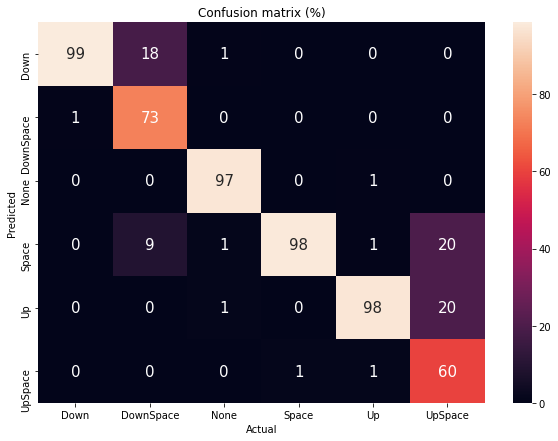

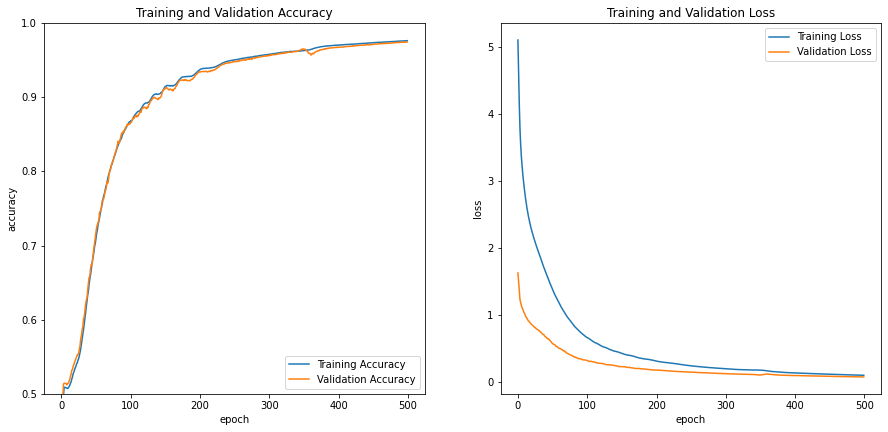

In [185]:
printGraphs(tmodels['8'], val_X, y_test, results['8'], 500)

In [75]:
tmodels['9'] = tf.keras.Sequential([  
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
tmodels['9'].compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results['9'] = tmodels['9'].fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=400,
               class_weight=weights)

Epoch 1/400
8/8 [==============================] - 1s 53ms/step - loss: 5.3175 - accuracy: 0.0334 - val_loss: 1.7309 - val_accuracy: 0.4446
Epoch 2/400
8/8 [==============================] - 0s 24ms/step - loss: 5.0139 - accuracy: 0.4664 - val_loss: 1.6374 - val_accuracy: 0.4945
Epoch 3/400
8/8 [==============================] - 0s 25ms/step - loss: 4.7321 - accuracy: 0.4872 - val_loss: 1.5353 - val_accuracy: 0.4950
Epoch 4/400
8/8 [==============================] - 0s 24ms/step - loss: 4.4338 - accuracy: 0.4911 - val_loss: 1.4113 - val_accuracy: 0.5085
Epoch 5/400
8/8 [==============================] - 0s 24ms/step - loss: 4.1438 - accuracy: 0.5031 - val_loss: 1.3212 - val_accuracy: 0.5142
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 3.9003 - accuracy: 0.5093 - val_loss: 1.2482 - val_accuracy: 0.5161
Epoch 7/400
8/8 [==============================] - 0s 24ms/step - loss: 3.7085 - accuracy: 0.5109 - val_loss: 1.2051 - val_accuracy: 0.5151
Epoch 8/400
8/8 [===

8/8 [==============================] - 0s 26ms/step - loss: 1.7129 - accuracy: 0.6440 - val_loss: 0.6975 - val_accuracy: 0.6514
Epoch 60/400
8/8 [==============================] - 0s 24ms/step - loss: 1.6964 - accuracy: 0.6453 - val_loss: 0.6841 - val_accuracy: 0.6591
Epoch 61/400
8/8 [==============================] - 0s 23ms/step - loss: 1.6765 - accuracy: 0.6529 - val_loss: 0.6862 - val_accuracy: 0.6577
Epoch 62/400
8/8 [==============================] - 0s 24ms/step - loss: 1.6596 - accuracy: 0.6517 - val_loss: 0.6706 - val_accuracy: 0.6656
Epoch 63/400
8/8 [==============================] - 0s 24ms/step - loss: 1.6413 - accuracy: 0.6588 - val_loss: 0.6742 - val_accuracy: 0.6641
Epoch 64/400
8/8 [==============================] - 0s 24ms/step - loss: 1.6232 - accuracy: 0.6581 - val_loss: 0.6594 - val_accuracy: 0.6726
Epoch 65/400
8/8 [==============================] - 0s 24ms/step - loss: 1.6056 - accuracy: 0.6642 - val_loss: 0.6524 - val_accuracy: 0.6764
Epoch 66/400
8/8 [========

8/8 [==============================] - 0s 23ms/step - loss: 0.8956 - accuracy: 0.8231 - val_loss: 0.3982 - val_accuracy: 0.8265
Epoch 118/400
8/8 [==============================] - 0s 23ms/step - loss: 0.8864 - accuracy: 0.8249 - val_loss: 0.3927 - val_accuracy: 0.8287
Epoch 119/400
8/8 [==============================] - 0s 25ms/step - loss: 0.8784 - accuracy: 0.8270 - val_loss: 0.3925 - val_accuracy: 0.8297
Epoch 120/400
8/8 [==============================] - 0s 22ms/step - loss: 0.8699 - accuracy: 0.8274 - val_loss: 0.3867 - val_accuracy: 0.8319
Epoch 121/400
8/8 [==============================] - 0s 24ms/step - loss: 0.8616 - accuracy: 0.8301 - val_loss: 0.3871 - val_accuracy: 0.8324
Epoch 122/400
8/8 [==============================] - 0s 23ms/step - loss: 0.8529 - accuracy: 0.8300 - val_loss: 0.3771 - val_accuracy: 0.8363
Epoch 123/400
8/8 [==============================] - 0s 23ms/step - loss: 0.8444 - accuracy: 0.8338 - val_loss: 0.3822 - val_accuracy: 0.8345
Epoch 124/400
8/8 [=

Epoch 175/400
8/8 [==============================] - 0s 23ms/step - loss: 0.5515 - accuracy: 0.8894 - val_loss: 0.2735 - val_accuracy: 0.8903
Epoch 176/400
8/8 [==============================] - 0s 23ms/step - loss: 0.5485 - accuracy: 0.8889 - val_loss: 0.2732 - val_accuracy: 0.8903
Epoch 177/400
8/8 [==============================] - 0s 23ms/step - loss: 0.5442 - accuracy: 0.8902 - val_loss: 0.2690 - val_accuracy: 0.8921
Epoch 178/400
8/8 [==============================] - 0s 24ms/step - loss: 0.5407 - accuracy: 0.8912 - val_loss: 0.2702 - val_accuracy: 0.8915
Epoch 179/400
8/8 [==============================] - 0s 23ms/step - loss: 0.5364 - accuracy: 0.8914 - val_loss: 0.2668 - val_accuracy: 0.8937
Epoch 180/400
8/8 [==============================] - 0s 24ms/step - loss: 0.5332 - accuracy: 0.8921 - val_loss: 0.2662 - val_accuracy: 0.8938
Epoch 181/400
8/8 [==============================] - 0s 24ms/step - loss: 0.5294 - accuracy: 0.8931 - val_loss: 0.2646 - val_accuracy: 0.8942
Epoch 

Epoch 233/400
8/8 [==============================] - 0s 24ms/step - loss: 0.3893 - accuracy: 0.9222 - val_loss: 0.2103 - val_accuracy: 0.9207
Epoch 234/400
8/8 [==============================] - 0s 23ms/step - loss: 0.3883 - accuracy: 0.9222 - val_loss: 0.2113 - val_accuracy: 0.9200
Epoch 235/400
8/8 [==============================] - 0s 23ms/step - loss: 0.3873 - accuracy: 0.9219 - val_loss: 0.2105 - val_accuracy: 0.9203
Epoch 236/400
8/8 [==============================] - 0s 23ms/step - loss: 0.3858 - accuracy: 0.9223 - val_loss: 0.2105 - val_accuracy: 0.9199
Epoch 237/400
8/8 [==============================] - 0s 24ms/step - loss: 0.3845 - accuracy: 0.9214 - val_loss: 0.2084 - val_accuracy: 0.9206
Epoch 238/400
8/8 [==============================] - 0s 23ms/step - loss: 0.3827 - accuracy: 0.9225 - val_loss: 0.2067 - val_accuracy: 0.9215
Epoch 239/400
8/8 [==============================] - 0s 23ms/step - loss: 0.3792 - accuracy: 0.9228 - val_loss: 0.2027 - val_accuracy: 0.9234
Epoch 

Epoch 291/400
8/8 [==============================] - 0s 25ms/step - loss: 0.2953 - accuracy: 0.9429 - val_loss: 0.1702 - val_accuracy: 0.9416
Epoch 292/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2951 - accuracy: 0.9426 - val_loss: 0.1675 - val_accuracy: 0.9426
Epoch 293/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2937 - accuracy: 0.9431 - val_loss: 0.1657 - val_accuracy: 0.9437
Epoch 294/400
8/8 [==============================] - 0s 25ms/step - loss: 0.2924 - accuracy: 0.9439 - val_loss: 0.1670 - val_accuracy: 0.9428
Epoch 295/400
8/8 [==============================] - 0s 24ms/step - loss: 0.2906 - accuracy: 0.9441 - val_loss: 0.1671 - val_accuracy: 0.9430
Epoch 296/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2902 - accuracy: 0.9439 - val_loss: 0.1657 - val_accuracy: 0.9435
Epoch 297/400
8/8 [==============================] - 0s 24ms/step - loss: 0.2885 - accuracy: 0.9445 - val_loss: 0.1652 - val_accuracy: 0.9437
Epoch 

Epoch 349/400
8/8 [==============================] - 0s 26ms/step - loss: 0.2367 - accuracy: 0.9535 - val_loss: 0.1376 - val_accuracy: 0.9540
Epoch 350/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2356 - accuracy: 0.9541 - val_loss: 0.1377 - val_accuracy: 0.9536
Epoch 351/400
8/8 [==============================] - 0s 25ms/step - loss: 0.2347 - accuracy: 0.9542 - val_loss: 0.1385 - val_accuracy: 0.9534
Epoch 352/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2342 - accuracy: 0.9542 - val_loss: 0.1377 - val_accuracy: 0.9539
Epoch 353/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2334 - accuracy: 0.9542 - val_loss: 0.1360 - val_accuracy: 0.9547
Epoch 354/400
8/8 [==============================] - 0s 26ms/step - loss: 0.2334 - accuracy: 0.9544 - val_loss: 0.1364 - val_accuracy: 0.9546
Epoch 355/400
8/8 [==============================] - 0s 23ms/step - loss: 0.2323 - accuracy: 0.9546 - val_loss: 0.1378 - val_accuracy: 0.9539
Epoch 

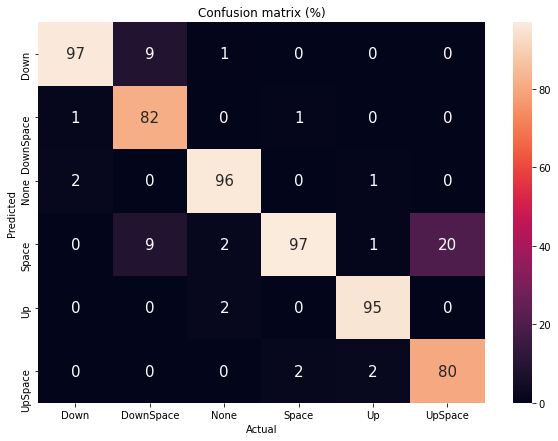

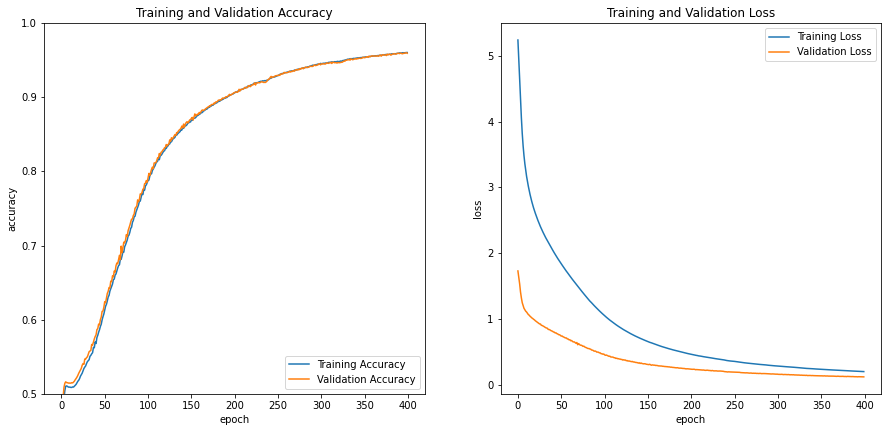

In [76]:
printGraphs(tmodels['9'], val_X, y_test, results['9'], 400)

In [188]:
t_final = tf.keras.Sequential([  
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
t_final.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
results_final = t_final.fit(train_ds_xl,
               validation_data=val_ds_xl,
               epochs=5000,
               class_weight=weights)

Epoch 1/5000
8/8 [==============================] - 0s 25ms/step - loss: 5.3949 - accuracy: 0.1915 - val_loss: 1.7363 - val_accuracy: 0.2338
Epoch 2/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.2338 - accuracy: 0.2740 - val_loss: 1.7333 - val_accuracy: 0.4625
Epoch 3/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.1033 - accuracy: 0.4558 - val_loss: 1.7038 - val_accuracy: 0.4539
Epoch 4/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.9775 - accuracy: 0.4484 - val_loss: 1.6584 - val_accuracy: 0.4533
Epoch 5/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.8557 - accuracy: 0.4494 - val_loss: 1.6089 - val_accuracy: 0.4620
Epoch 6/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.7371 - accuracy: 0.4605 - val_loss: 1.5644 - val_accuracy: 0.4662
Epoch 7/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.6199 - accuracy: 0.4635 - val_loss: 1.5268 - val_accuracy: 0.4739
Epoch 8/5000


Epoch 59/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.7746 - accuracy: 0.5126 - val_loss: 1.0299 - val_accuracy: 0.5183
Epoch 60/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.7623 - accuracy: 0.5126 - val_loss: 1.0266 - val_accuracy: 0.5182
Epoch 61/5000
8/8 [==============================] - 0s 17ms/step - loss: 2.7507 - accuracy: 0.5125 - val_loss: 1.0250 - val_accuracy: 0.5180
Epoch 62/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.7385 - accuracy: 0.5125 - val_loss: 1.0197 - val_accuracy: 0.5180
Epoch 63/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.7271 - accuracy: 0.5127 - val_loss: 1.0173 - val_accuracy: 0.5180
Epoch 64/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.7156 - accuracy: 0.5126 - val_loss: 1.0141 - val_accuracy: 0.5178
Epoch 65/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.7042 - accuracy: 0.5125 - val_loss: 1.0108 - val_accuracy: 0.5179
Epoch 

8/8 [==============================] - 0s 12ms/step - loss: 2.2724 - accuracy: 0.5360 - val_loss: 0.8759 - val_accuracy: 0.5404
Epoch 117/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.2660 - accuracy: 0.5371 - val_loss: 0.8738 - val_accuracy: 0.5410
Epoch 118/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.2591 - accuracy: 0.5382 - val_loss: 0.8716 - val_accuracy: 0.5425
Epoch 119/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.2529 - accuracy: 0.5396 - val_loss: 0.8695 - val_accuracy: 0.5431
Epoch 120/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.2464 - accuracy: 0.5401 - val_loss: 0.8679 - val_accuracy: 0.5437
Epoch 121/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.2402 - accuracy: 0.5408 - val_loss: 0.8660 - val_accuracy: 0.5448
Epoch 122/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.2336 - accuracy: 0.5428 - val_loss: 0.8621 - val_accuracy: 0.5463
Epoch 123/5000

8/8 [==============================] - 0s 13ms/step - loss: 1.9358 - accuracy: 0.5957 - val_loss: 0.7718 - val_accuracy: 0.5972
Epoch 174/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.9304 - accuracy: 0.5961 - val_loss: 0.7721 - val_accuracy: 0.5973
Epoch 175/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.9249 - accuracy: 0.5962 - val_loss: 0.7698 - val_accuracy: 0.5989
Epoch 176/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.9195 - accuracy: 0.5976 - val_loss: 0.7696 - val_accuracy: 0.5987
Epoch 177/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.9138 - accuracy: 0.5977 - val_loss: 0.7652 - val_accuracy: 0.6013
Epoch 178/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.9082 - accuracy: 0.5997 - val_loss: 0.7653 - val_accuracy: 0.6012
Epoch 179/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.9032 - accuracy: 0.5998 - val_loss: 0.7628 - val_accuracy: 0.6027
Epoch 180/5000

8/8 [==============================] - 0s 12ms/step - loss: 1.6289 - accuracy: 0.6509 - val_loss: 0.6740 - val_accuracy: 0.6535
Epoch 231/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.6237 - accuracy: 0.6525 - val_loss: 0.6740 - val_accuracy: 0.6533
Epoch 232/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.6187 - accuracy: 0.6522 - val_loss: 0.6730 - val_accuracy: 0.6543
Epoch 233/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.6138 - accuracy: 0.6543 - val_loss: 0.6672 - val_accuracy: 0.6576
Epoch 234/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.6087 - accuracy: 0.6562 - val_loss: 0.6703 - val_accuracy: 0.6558
Epoch 235/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.6036 - accuracy: 0.6555 - val_loss: 0.6655 - val_accuracy: 0.6586
Epoch 236/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.5987 - accuracy: 0.6578 - val_loss: 0.6663 - val_accuracy: 0.6585
Epoch 237/5000

8/8 [==============================] - 0s 13ms/step - loss: 1.3612 - accuracy: 0.6970 - val_loss: 0.5885 - val_accuracy: 0.7000
Epoch 288/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.3567 - accuracy: 0.6987 - val_loss: 0.5913 - val_accuracy: 0.6984
Epoch 289/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.3541 - accuracy: 0.6975 - val_loss: 0.5868 - val_accuracy: 0.7013
Epoch 290/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.3498 - accuracy: 0.7008 - val_loss: 0.5864 - val_accuracy: 0.7008
Epoch 291/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.3461 - accuracy: 0.6986 - val_loss: 0.5870 - val_accuracy: 0.7008
Epoch 292/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.3427 - accuracy: 0.7013 - val_loss: 0.5819 - val_accuracy: 0.7045
Epoch 293/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.3388 - accuracy: 0.7023 - val_loss: 0.5843 - val_accuracy: 0.7031
Epoch 294/5000

8/8 [==============================] - 0s 12ms/step - loss: 1.1794 - accuracy: 0.7372 - val_loss: 0.5317 - val_accuracy: 0.7376
Epoch 345/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.1770 - accuracy: 0.7373 - val_loss: 0.5256 - val_accuracy: 0.7407
Epoch 346/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1741 - accuracy: 0.7390 - val_loss: 0.5307 - val_accuracy: 0.7384
Epoch 347/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.1715 - accuracy: 0.7379 - val_loss: 0.5249 - val_accuracy: 0.7420
Epoch 348/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1689 - accuracy: 0.7400 - val_loss: 0.5257 - val_accuracy: 0.7409
Epoch 349/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1662 - accuracy: 0.7398 - val_loss: 0.5253 - val_accuracy: 0.7415
Epoch 350/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1634 - accuracy: 0.7406 - val_loss: 0.5221 - val_accuracy: 0.7442
Epoch 351/5000

8/8 [==============================] - 0s 13ms/step - loss: 1.0466 - accuracy: 0.7701 - val_loss: 0.4830 - val_accuracy: 0.7699
Epoch 402/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.0450 - accuracy: 0.7684 - val_loss: 0.4789 - val_accuracy: 0.7726
Epoch 403/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.0427 - accuracy: 0.7712 - val_loss: 0.4828 - val_accuracy: 0.7687
Epoch 404/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.0409 - accuracy: 0.7682 - val_loss: 0.4768 - val_accuracy: 0.7741
Epoch 405/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.0385 - accuracy: 0.7735 - val_loss: 0.4806 - val_accuracy: 0.7712
Epoch 406/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.0367 - accuracy: 0.7693 - val_loss: 0.4763 - val_accuracy: 0.7743
Epoch 407/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.0346 - accuracy: 0.7739 - val_loss: 0.4794 - val_accuracy: 0.7720
Epoch 408/5000

8/8 [==============================] - 0s 13ms/step - loss: 0.9432 - accuracy: 0.7944 - val_loss: 0.4418 - val_accuracy: 0.7973
Epoch 459/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.9413 - accuracy: 0.7968 - val_loss: 0.4439 - val_accuracy: 0.7959
Epoch 460/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.9398 - accuracy: 0.7958 - val_loss: 0.4417 - val_accuracy: 0.7968
Epoch 461/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.9382 - accuracy: 0.7960 - val_loss: 0.4410 - val_accuracy: 0.7978
Epoch 462/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.9365 - accuracy: 0.7976 - val_loss: 0.4413 - val_accuracy: 0.7979
Epoch 463/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.9350 - accuracy: 0.7972 - val_loss: 0.4391 - val_accuracy: 0.7993
Epoch 464/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.9333 - accuracy: 0.7983 - val_loss: 0.4408 - val_accuracy: 0.7980
Epoch 465/5000

8/8 [==============================] - 0s 12ms/step - loss: 0.8593 - accuracy: 0.8182 - val_loss: 0.4122 - val_accuracy: 0.8166
Epoch 516/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.8586 - accuracy: 0.8173 - val_loss: 0.4095 - val_accuracy: 0.8190
Epoch 517/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.8565 - accuracy: 0.8196 - val_loss: 0.4127 - val_accuracy: 0.8161
Epoch 518/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.8557 - accuracy: 0.8169 - val_loss: 0.4079 - val_accuracy: 0.8200
Epoch 519/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.8542 - accuracy: 0.8197 - val_loss: 0.4105 - val_accuracy: 0.8183
Epoch 520/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.8531 - accuracy: 0.8194 - val_loss: 0.4083 - val_accuracy: 0.8192
Epoch 521/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.8514 - accuracy: 0.8191 - val_loss: 0.4081 - val_accuracy: 0.8195
Epoch 522/5000

8/8 [==============================] - 0s 14ms/step - loss: 0.7897 - accuracy: 0.8335 - val_loss: 0.3846 - val_accuracy: 0.8333
Epoch 573/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.7884 - accuracy: 0.8342 - val_loss: 0.3848 - val_accuracy: 0.8326
Epoch 574/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.7877 - accuracy: 0.8341 - val_loss: 0.3833 - val_accuracy: 0.8342
Epoch 575/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.7860 - accuracy: 0.8350 - val_loss: 0.3838 - val_accuracy: 0.8330
Epoch 576/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.7854 - accuracy: 0.8344 - val_loss: 0.3831 - val_accuracy: 0.8338
Epoch 577/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.7839 - accuracy: 0.8349 - val_loss: 0.3814 - val_accuracy: 0.8348
Epoch 578/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.7832 - accuracy: 0.8360 - val_loss: 0.3837 - val_accuracy: 0.8336
Epoch 579/5000

8/8 [==============================] - 0s 12ms/step - loss: 0.7314 - accuracy: 0.8461 - val_loss: 0.3593 - val_accuracy: 0.8474
Epoch 630/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.7302 - accuracy: 0.8479 - val_loss: 0.3636 - val_accuracy: 0.8447
Epoch 631/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.7295 - accuracy: 0.8466 - val_loss: 0.3587 - val_accuracy: 0.8477
Epoch 632/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.7284 - accuracy: 0.8477 - val_loss: 0.3617 - val_accuracy: 0.8454
Epoch 633/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.7278 - accuracy: 0.8472 - val_loss: 0.3591 - val_accuracy: 0.8473
Epoch 634/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.7265 - accuracy: 0.8482 - val_loss: 0.3605 - val_accuracy: 0.8462
Epoch 635/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.7259 - accuracy: 0.8479 - val_loss: 0.3590 - val_accuracy: 0.8473
Epoch 636/5000

8/8 [==============================] - 0s 14ms/step - loss: 0.6812 - accuracy: 0.8575 - val_loss: 0.3411 - val_accuracy: 0.8555
Epoch 687/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6807 - accuracy: 0.8571 - val_loss: 0.3397 - val_accuracy: 0.8562
Epoch 688/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6797 - accuracy: 0.8580 - val_loss: 0.3400 - val_accuracy: 0.8560
Epoch 689/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.6791 - accuracy: 0.8582 - val_loss: 0.3428 - val_accuracy: 0.8550
Epoch 690/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6780 - accuracy: 0.8574 - val_loss: 0.3375 - val_accuracy: 0.8571
Epoch 691/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6776 - accuracy: 0.8585 - val_loss: 0.3407 - val_accuracy: 0.8559
Epoch 692/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6765 - accuracy: 0.8583 - val_loss: 0.3392 - val_accuracy: 0.8561
Epoch 693/5000

8/8 [==============================] - 0s 12ms/step - loss: 0.6375 - accuracy: 0.8656 - val_loss: 0.3203 - val_accuracy: 0.8664
Epoch 744/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.6368 - accuracy: 0.8675 - val_loss: 0.3242 - val_accuracy: 0.8634
Epoch 745/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.6361 - accuracy: 0.8663 - val_loss: 0.3220 - val_accuracy: 0.8653
Epoch 746/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.6350 - accuracy: 0.8675 - val_loss: 0.3213 - val_accuracy: 0.8653
Epoch 747/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6351 - accuracy: 0.8672 - val_loss: 0.3227 - val_accuracy: 0.8648
Epoch 748/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.6338 - accuracy: 0.8675 - val_loss: 0.3210 - val_accuracy: 0.8653
Epoch 749/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.6331 - accuracy: 0.8672 - val_loss: 0.3216 - val_accuracy: 0.8652
Epoch 750/5000

8/8 [==============================] - 0s 12ms/step - loss: 0.5988 - accuracy: 0.8746 - val_loss: 0.3054 - val_accuracy: 0.8747
Epoch 801/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5984 - accuracy: 0.8756 - val_loss: 0.3070 - val_accuracy: 0.8737
Epoch 802/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.5976 - accuracy: 0.8751 - val_loss: 0.3048 - val_accuracy: 0.8748
Epoch 803/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.5971 - accuracy: 0.8756 - val_loss: 0.3071 - val_accuracy: 0.8735
Epoch 804/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.5964 - accuracy: 0.8754 - val_loss: 0.3035 - val_accuracy: 0.8758
Epoch 805/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.5957 - accuracy: 0.8760 - val_loss: 0.3061 - val_accuracy: 0.8739
Epoch 806/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5950 - accuracy: 0.8755 - val_loss: 0.3027 - val_accuracy: 0.8761
Epoch 807/5000

8/8 [==============================] - 0s 13ms/step - loss: 0.5642 - accuracy: 0.8828 - val_loss: 0.2922 - val_accuracy: 0.8817
Epoch 858/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5637 - accuracy: 0.8829 - val_loss: 0.2907 - val_accuracy: 0.8825
Epoch 859/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5630 - accuracy: 0.8831 - val_loss: 0.2904 - val_accuracy: 0.8825
Epoch 860/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5624 - accuracy: 0.8836 - val_loss: 0.2915 - val_accuracy: 0.8818
Epoch 861/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.5620 - accuracy: 0.8830 - val_loss: 0.2900 - val_accuracy: 0.8829
Epoch 862/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.5613 - accuracy: 0.8836 - val_loss: 0.2890 - val_accuracy: 0.8834
Epoch 863/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5608 - accuracy: 0.8840 - val_loss: 0.2917 - val_accuracy: 0.8819
Epoch 864/5000

8/8 [==============================] - 0s 13ms/step - loss: 0.5322 - accuracy: 0.8907 - val_loss: 0.2799 - val_accuracy: 0.8884
Epoch 915/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.5316 - accuracy: 0.8896 - val_loss: 0.2742 - val_accuracy: 0.8913
Epoch 916/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.5311 - accuracy: 0.8910 - val_loss: 0.2784 - val_accuracy: 0.8893
Epoch 917/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.5305 - accuracy: 0.8908 - val_loss: 0.2770 - val_accuracy: 0.8899
Epoch 918/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.5300 - accuracy: 0.8904 - val_loss: 0.2773 - val_accuracy: 0.8897
Epoch 919/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.5295 - accuracy: 0.8906 - val_loss: 0.2757 - val_accuracy: 0.8904
Epoch 920/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.5291 - accuracy: 0.8910 - val_loss: 0.2766 - val_accuracy: 0.8903
Epoch 921/5000

8/8 [==============================] - 0s 12ms/step - loss: 0.5035 - accuracy: 0.8965 - val_loss: 0.2661 - val_accuracy: 0.8952
Epoch 972/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5032 - accuracy: 0.8962 - val_loss: 0.2655 - val_accuracy: 0.8957
Epoch 973/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.5026 - accuracy: 0.8964 - val_loss: 0.2619 - val_accuracy: 0.8972
Epoch 974/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5021 - accuracy: 0.8970 - val_loss: 0.2661 - val_accuracy: 0.8954
Epoch 975/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5016 - accuracy: 0.8964 - val_loss: 0.2629 - val_accuracy: 0.8968
Epoch 976/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.5013 - accuracy: 0.8972 - val_loss: 0.2644 - val_accuracy: 0.8964
Epoch 977/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.5006 - accuracy: 0.8967 - val_loss: 0.2626 - val_accuracy: 0.8971
Epoch 978/5000

8/8 [==============================] - 0s 12ms/step - loss: 0.4778 - accuracy: 0.9015 - val_loss: 0.2537 - val_accuracy: 0.9020
Epoch 1029/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4771 - accuracy: 0.9015 - val_loss: 0.2522 - val_accuracy: 0.9028
Epoch 1030/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4768 - accuracy: 0.9022 - val_loss: 0.2544 - val_accuracy: 0.9015
Epoch 1031/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4764 - accuracy: 0.9016 - val_loss: 0.2526 - val_accuracy: 0.9023
Epoch 1032/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4760 - accuracy: 0.9019 - val_loss: 0.2525 - val_accuracy: 0.9028
Epoch 1033/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4754 - accuracy: 0.9019 - val_loss: 0.2519 - val_accuracy: 0.9029
Epoch 1034/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4753 - accuracy: 0.9026 - val_loss: 0.2533 - val_accuracy: 0.9022
Epoch 10

8/8 [==============================] - 0s 13ms/step - loss: 0.4545 - accuracy: 0.9067 - val_loss: 0.2424 - val_accuracy: 0.9077
Epoch 1086/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4541 - accuracy: 0.9070 - val_loss: 0.2439 - val_accuracy: 0.9070
Epoch 1087/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4536 - accuracy: 0.9066 - val_loss: 0.2427 - val_accuracy: 0.9074
Epoch 1088/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4534 - accuracy: 0.9070 - val_loss: 0.2431 - val_accuracy: 0.9074
Epoch 1089/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4529 - accuracy: 0.9067 - val_loss: 0.2417 - val_accuracy: 0.9080
Epoch 1090/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.4527 - accuracy: 0.9072 - val_loss: 0.2432 - val_accuracy: 0.9073
Epoch 1091/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.4522 - accuracy: 0.9071 - val_loss: 0.2412 - val_accuracy: 0.9083
Epoch 10

8/8 [==============================] - 0s 13ms/step - loss: 0.4335 - accuracy: 0.9114 - val_loss: 0.2343 - val_accuracy: 0.9118
Epoch 1143/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4331 - accuracy: 0.9108 - val_loss: 0.2331 - val_accuracy: 0.9125
Epoch 1144/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4328 - accuracy: 0.9113 - val_loss: 0.2327 - val_accuracy: 0.9125
Epoch 1145/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4326 - accuracy: 0.9115 - val_loss: 0.2340 - val_accuracy: 0.9120
Epoch 1146/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4320 - accuracy: 0.9115 - val_loss: 0.2338 - val_accuracy: 0.9120
Epoch 1147/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4317 - accuracy: 0.9110 - val_loss: 0.2327 - val_accuracy: 0.9125
Epoch 1148/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4316 - accuracy: 0.9116 - val_loss: 0.2334 - val_accuracy: 0.9124
Epoch 11

8/8 [==============================] - 0s 13ms/step - loss: 0.4144 - accuracy: 0.9152 - val_loss: 0.2243 - val_accuracy: 0.9169
Epoch 1200/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4142 - accuracy: 0.9153 - val_loss: 0.2252 - val_accuracy: 0.9167
Epoch 1201/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.4138 - accuracy: 0.9153 - val_loss: 0.2238 - val_accuracy: 0.9171
Epoch 1202/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4133 - accuracy: 0.9156 - val_loss: 0.2259 - val_accuracy: 0.9163
Epoch 1203/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.4132 - accuracy: 0.9153 - val_loss: 0.2250 - val_accuracy: 0.9167
Epoch 1204/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4127 - accuracy: 0.9154 - val_loss: 0.2239 - val_accuracy: 0.9171
Epoch 1205/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.4126 - accuracy: 0.9154 - val_loss: 0.2231 - val_accuracy: 0.9176
Epoch 12

8/8 [==============================] - 0s 12ms/step - loss: 0.3971 - accuracy: 0.9191 - val_loss: 0.2167 - val_accuracy: 0.9209
Epoch 1257/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3966 - accuracy: 0.9193 - val_loss: 0.2170 - val_accuracy: 0.9208
Epoch 1258/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3965 - accuracy: 0.9192 - val_loss: 0.2170 - val_accuracy: 0.9208
Epoch 1259/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3960 - accuracy: 0.9189 - val_loss: 0.2159 - val_accuracy: 0.9212
Epoch 1260/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3957 - accuracy: 0.9194 - val_loss: 0.2165 - val_accuracy: 0.9211
Epoch 1261/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3955 - accuracy: 0.9193 - val_loss: 0.2163 - val_accuracy: 0.9209
Epoch 1262/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.3952 - accuracy: 0.9195 - val_loss: 0.2157 - val_accuracy: 0.9215
Epoch 12

8/8 [==============================] - 0s 12ms/step - loss: 0.3805 - accuracy: 0.9230 - val_loss: 0.2087 - val_accuracy: 0.9248
Epoch 1314/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3803 - accuracy: 0.9236 - val_loss: 0.2110 - val_accuracy: 0.9236
Epoch 1315/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3801 - accuracy: 0.9227 - val_loss: 0.2083 - val_accuracy: 0.9249
Epoch 1316/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3799 - accuracy: 0.9230 - val_loss: 0.2079 - val_accuracy: 0.9250
Epoch 1317/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3796 - accuracy: 0.9235 - val_loss: 0.2088 - val_accuracy: 0.9249
Epoch 1318/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3793 - accuracy: 0.9236 - val_loss: 0.2091 - val_accuracy: 0.9248
Epoch 1319/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3791 - accuracy: 0.9233 - val_loss: 0.2084 - val_accuracy: 0.9250
Epoch 13

8/8 [==============================] - 0s 14ms/step - loss: 0.3655 - accuracy: 0.9261 - val_loss: 0.2014 - val_accuracy: 0.9285
Epoch 1371/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3653 - accuracy: 0.9266 - val_loss: 0.2022 - val_accuracy: 0.9282
Epoch 1372/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3650 - accuracy: 0.9264 - val_loss: 0.2023 - val_accuracy: 0.9280
Epoch 1373/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3649 - accuracy: 0.9261 - val_loss: 0.2002 - val_accuracy: 0.9289
Epoch 1374/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3645 - accuracy: 0.9269 - val_loss: 0.2017 - val_accuracy: 0.9283
Epoch 1375/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3644 - accuracy: 0.9264 - val_loss: 0.2022 - val_accuracy: 0.9282
Epoch 1376/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3640 - accuracy: 0.9266 - val_loss: 0.2005 - val_accuracy: 0.9286
Epoch 13

8/8 [==============================] - 0s 12ms/step - loss: 0.3519 - accuracy: 0.9294 - val_loss: 0.1969 - val_accuracy: 0.9300
Epoch 1428/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3516 - accuracy: 0.9288 - val_loss: 0.1956 - val_accuracy: 0.9302
Epoch 1429/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3515 - accuracy: 0.9293 - val_loss: 0.1959 - val_accuracy: 0.9303
Epoch 1430/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3512 - accuracy: 0.9291 - val_loss: 0.1949 - val_accuracy: 0.9306
Epoch 1431/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3510 - accuracy: 0.9297 - val_loss: 0.1965 - val_accuracy: 0.9300
Epoch 1432/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3509 - accuracy: 0.9292 - val_loss: 0.1958 - val_accuracy: 0.9304
Epoch 1433/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3505 - accuracy: 0.9293 - val_loss: 0.1945 - val_accuracy: 0.9307
Epoch 14

8/8 [==============================] - 0s 13ms/step - loss: 0.3395 - accuracy: 0.9312 - val_loss: 0.1911 - val_accuracy: 0.9322
Epoch 1485/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3391 - accuracy: 0.9315 - val_loss: 0.1904 - val_accuracy: 0.9324
Epoch 1486/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3389 - accuracy: 0.9316 - val_loss: 0.1908 - val_accuracy: 0.9323
Epoch 1487/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3390 - accuracy: 0.9312 - val_loss: 0.1903 - val_accuracy: 0.9325
Epoch 1488/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3384 - accuracy: 0.9315 - val_loss: 0.1898 - val_accuracy: 0.9326
Epoch 1489/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3385 - accuracy: 0.9317 - val_loss: 0.1896 - val_accuracy: 0.9330
Epoch 1490/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3383 - accuracy: 0.9316 - val_loss: 0.1900 - val_accuracy: 0.9326
Epoch 14

8/8 [==============================] - 0s 13ms/step - loss: 0.3280 - accuracy: 0.9337 - val_loss: 0.1844 - val_accuracy: 0.9352
Epoch 1542/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3278 - accuracy: 0.9338 - val_loss: 0.1854 - val_accuracy: 0.9347
Epoch 1543/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3278 - accuracy: 0.9337 - val_loss: 0.1853 - val_accuracy: 0.9348
Epoch 1544/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3272 - accuracy: 0.9337 - val_loss: 0.1845 - val_accuracy: 0.9353
Epoch 1545/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3273 - accuracy: 0.9339 - val_loss: 0.1853 - val_accuracy: 0.9350
Epoch 1546/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3269 - accuracy: 0.9340 - val_loss: 0.1856 - val_accuracy: 0.9346
Epoch 1547/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3269 - accuracy: 0.9337 - val_loss: 0.1850 - val_accuracy: 0.9351
Epoch 15

8/8 [==============================] - 0s 13ms/step - loss: 0.3167 - accuracy: 0.9361 - val_loss: 0.1811 - val_accuracy: 0.9369
Epoch 1599/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.3165 - accuracy: 0.9360 - val_loss: 0.1803 - val_accuracy: 0.9373
Epoch 1600/5000
8/8 [==============================] - 0s 19ms/step - loss: 0.3163 - accuracy: 0.9359 - val_loss: 0.1796 - val_accuracy: 0.9376
Epoch 1601/5000
8/8 [==============================] - 0s 21ms/step - loss: 0.3161 - accuracy: 0.9364 - val_loss: 0.1807 - val_accuracy: 0.9370
Epoch 1602/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.3160 - accuracy: 0.9359 - val_loss: 0.1799 - val_accuracy: 0.9375
Epoch 1603/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.3157 - accuracy: 0.9363 - val_loss: 0.1787 - val_accuracy: 0.9377
Epoch 1604/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.3155 - accuracy: 0.9365 - val_loss: 0.1802 - val_accuracy: 0.9374
Epoch 16

8/8 [==============================] - 0s 13ms/step - loss: 0.3062 - accuracy: 0.9385 - val_loss: 0.1756 - val_accuracy: 0.9390
Epoch 1656/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.3061 - accuracy: 0.9383 - val_loss: 0.1759 - val_accuracy: 0.9391
Epoch 1657/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3060 - accuracy: 0.9384 - val_loss: 0.1759 - val_accuracy: 0.9392
Epoch 1658/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3056 - accuracy: 0.9385 - val_loss: 0.1750 - val_accuracy: 0.9393
Epoch 1659/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3058 - accuracy: 0.9383 - val_loss: 0.1744 - val_accuracy: 0.9395
Epoch 1660/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.3054 - accuracy: 0.9387 - val_loss: 0.1746 - val_accuracy: 0.9396
Epoch 1661/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.3053 - accuracy: 0.9385 - val_loss: 0.1755 - val_accuracy: 0.9392
Epoch 16

8/8 [==============================] - 0s 15ms/step - loss: 0.2965 - accuracy: 0.9404 - val_loss: 0.1707 - val_accuracy: 0.9413
Epoch 1713/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2962 - accuracy: 0.9402 - val_loss: 0.1707 - val_accuracy: 0.9412
Epoch 1714/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2961 - accuracy: 0.9406 - val_loss: 0.1712 - val_accuracy: 0.9408
Epoch 1715/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2960 - accuracy: 0.9400 - val_loss: 0.1703 - val_accuracy: 0.9414
Epoch 1716/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2958 - accuracy: 0.9404 - val_loss: 0.1712 - val_accuracy: 0.9409
Epoch 1717/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2956 - accuracy: 0.9404 - val_loss: 0.1706 - val_accuracy: 0.9412
Epoch 1718/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2953 - accuracy: 0.9405 - val_loss: 0.1708 - val_accuracy: 0.9412
Epoch 17

8/8 [==============================] - 0s 14ms/step - loss: 0.2870 - accuracy: 0.9420 - val_loss: 0.1671 - val_accuracy: 0.9427
Epoch 1770/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2872 - accuracy: 0.9419 - val_loss: 0.1668 - val_accuracy: 0.9428
Epoch 1771/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2868 - accuracy: 0.9421 - val_loss: 0.1672 - val_accuracy: 0.9426
Epoch 1772/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2866 - accuracy: 0.9419 - val_loss: 0.1668 - val_accuracy: 0.9427
Epoch 1773/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2865 - accuracy: 0.9419 - val_loss: 0.1667 - val_accuracy: 0.9428
Epoch 1774/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2864 - accuracy: 0.9421 - val_loss: 0.1669 - val_accuracy: 0.9427
Epoch 1775/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2861 - accuracy: 0.9420 - val_loss: 0.1673 - val_accuracy: 0.9426
Epoch 17

8/8 [==============================] - 0s 12ms/step - loss: 0.2781 - accuracy: 0.9436 - val_loss: 0.1640 - val_accuracy: 0.9441
Epoch 1827/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2780 - accuracy: 0.9433 - val_loss: 0.1620 - val_accuracy: 0.9448
Epoch 1828/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2779 - accuracy: 0.9436 - val_loss: 0.1626 - val_accuracy: 0.9445
Epoch 1829/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2779 - accuracy: 0.9434 - val_loss: 0.1616 - val_accuracy: 0.9449
Epoch 1830/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2776 - accuracy: 0.9438 - val_loss: 0.1623 - val_accuracy: 0.9448
Epoch 1831/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2775 - accuracy: 0.9438 - val_loss: 0.1633 - val_accuracy: 0.9444
Epoch 1832/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2773 - accuracy: 0.9435 - val_loss: 0.1624 - val_accuracy: 0.9447
Epoch 18

8/8 [==============================] - 0s 12ms/step - loss: 0.2700 - accuracy: 0.9450 - val_loss: 0.1590 - val_accuracy: 0.9457
Epoch 1884/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2699 - accuracy: 0.9450 - val_loss: 0.1594 - val_accuracy: 0.9456
Epoch 1885/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2698 - accuracy: 0.9449 - val_loss: 0.1584 - val_accuracy: 0.9460
Epoch 1886/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2696 - accuracy: 0.9450 - val_loss: 0.1598 - val_accuracy: 0.9453
Epoch 1887/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2695 - accuracy: 0.9447 - val_loss: 0.1588 - val_accuracy: 0.9456
Epoch 1888/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2693 - accuracy: 0.9449 - val_loss: 0.1592 - val_accuracy: 0.9456
Epoch 1889/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2693 - accuracy: 0.9450 - val_loss: 0.1589 - val_accuracy: 0.9457
Epoch 18

8/8 [==============================] - 0s 13ms/step - loss: 0.2626 - accuracy: 0.9462 - val_loss: 0.1560 - val_accuracy: 0.9469
Epoch 1941/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2621 - accuracy: 0.9461 - val_loss: 0.1560 - val_accuracy: 0.9469
Epoch 1942/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2623 - accuracy: 0.9462 - val_loss: 0.1557 - val_accuracy: 0.9468
Epoch 1943/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2621 - accuracy: 0.9459 - val_loss: 0.1549 - val_accuracy: 0.9473
Epoch 1944/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2621 - accuracy: 0.9461 - val_loss: 0.1547 - val_accuracy: 0.9473
Epoch 1945/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2617 - accuracy: 0.9463 - val_loss: 0.1549 - val_accuracy: 0.9472
Epoch 1946/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2618 - accuracy: 0.9464 - val_loss: 0.1555 - val_accuracy: 0.9471
Epoch 19

8/8 [==============================] - 0s 13ms/step - loss: 0.2555 - accuracy: 0.9473 - val_loss: 0.1513 - val_accuracy: 0.9486
Epoch 1998/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2552 - accuracy: 0.9476 - val_loss: 0.1524 - val_accuracy: 0.9484
Epoch 1999/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2554 - accuracy: 0.9473 - val_loss: 0.1514 - val_accuracy: 0.9488
Epoch 2000/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2551 - accuracy: 0.9475 - val_loss: 0.1511 - val_accuracy: 0.9487
Epoch 2001/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2549 - accuracy: 0.9478 - val_loss: 0.1521 - val_accuracy: 0.9484
Epoch 2002/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2549 - accuracy: 0.9477 - val_loss: 0.1526 - val_accuracy: 0.9483
Epoch 2003/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2547 - accuracy: 0.9473 - val_loss: 0.1514 - val_accuracy: 0.9486
Epoch 20

8/8 [==============================] - 0s 14ms/step - loss: 0.2487 - accuracy: 0.9490 - val_loss: 0.1492 - val_accuracy: 0.9498
Epoch 2055/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.2488 - accuracy: 0.9487 - val_loss: 0.1480 - val_accuracy: 0.9502
Epoch 2056/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2484 - accuracy: 0.9491 - val_loss: 0.1480 - val_accuracy: 0.9499
Epoch 2057/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2485 - accuracy: 0.9491 - val_loss: 0.1493 - val_accuracy: 0.9496
Epoch 2058/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2483 - accuracy: 0.9492 - val_loss: 0.1487 - val_accuracy: 0.9499
Epoch 2059/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2482 - accuracy: 0.9490 - val_loss: 0.1479 - val_accuracy: 0.9503
Epoch 2060/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2478 - accuracy: 0.9492 - val_loss: 0.1487 - val_accuracy: 0.9499
Epoch 20

Epoch 2111/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2423 - accuracy: 0.9502 - val_loss: 0.1457 - val_accuracy: 0.9514
Epoch 2112/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2421 - accuracy: 0.9506 - val_loss: 0.1462 - val_accuracy: 0.9510
Epoch 2113/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2422 - accuracy: 0.9502 - val_loss: 0.1456 - val_accuracy: 0.9513
Epoch 2114/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2421 - accuracy: 0.9504 - val_loss: 0.1449 - val_accuracy: 0.9513
Epoch 2115/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.2418 - accuracy: 0.9504 - val_loss: 0.1447 - val_accuracy: 0.9518
Epoch 2116/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2420 - accuracy: 0.9507 - val_loss: 0.1451 - val_accuracy: 0.9513
Epoch 2117/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2416 - accuracy: 0.9504 - val_loss: 0.1451 - val_accuracy:

Epoch 2168/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2359 - accuracy: 0.9518 - val_loss: 0.1414 - val_accuracy: 0.9532
Epoch 2169/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2357 - accuracy: 0.9522 - val_loss: 0.1420 - val_accuracy: 0.9531
Epoch 2170/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2356 - accuracy: 0.9521 - val_loss: 0.1418 - val_accuracy: 0.9531
Epoch 2171/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2355 - accuracy: 0.9520 - val_loss: 0.1423 - val_accuracy: 0.9529
Epoch 2172/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2354 - accuracy: 0.9521 - val_loss: 0.1419 - val_accuracy: 0.9532
Epoch 2173/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2353 - accuracy: 0.9521 - val_loss: 0.1427 - val_accuracy: 0.9527
Epoch 2174/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2352 - accuracy: 0.9519 - val_loss: 0.1414 - val_accuracy:

Epoch 2225/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2301 - accuracy: 0.9530 - val_loss: 0.1389 - val_accuracy: 0.9541
Epoch 2226/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2298 - accuracy: 0.9531 - val_loss: 0.1386 - val_accuracy: 0.9544
Epoch 2227/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2297 - accuracy: 0.9533 - val_loss: 0.1393 - val_accuracy: 0.9542
Epoch 2228/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2295 - accuracy: 0.9531 - val_loss: 0.1388 - val_accuracy: 0.9543
Epoch 2229/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2294 - accuracy: 0.9532 - val_loss: 0.1392 - val_accuracy: 0.9541
Epoch 2230/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2295 - accuracy: 0.9530 - val_loss: 0.1386 - val_accuracy: 0.9542
Epoch 2231/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2293 - accuracy: 0.9532 - val_loss: 0.1385 - val_accuracy:

Epoch 2282/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2246 - accuracy: 0.9539 - val_loss: 0.1360 - val_accuracy: 0.9551
Epoch 2283/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2243 - accuracy: 0.9541 - val_loss: 0.1361 - val_accuracy: 0.9549
Epoch 2284/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2242 - accuracy: 0.9541 - val_loss: 0.1364 - val_accuracy: 0.9549
Epoch 2285/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.2242 - accuracy: 0.9541 - val_loss: 0.1358 - val_accuracy: 0.9552
Epoch 2286/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2241 - accuracy: 0.9542 - val_loss: 0.1358 - val_accuracy: 0.9551
Epoch 2287/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2241 - accuracy: 0.9542 - val_loss: 0.1363 - val_accuracy: 0.9547
Epoch 2288/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2240 - accuracy: 0.9541 - val_loss: 0.1357 - val_accuracy:

Epoch 2339/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2194 - accuracy: 0.9550 - val_loss: 0.1342 - val_accuracy: 0.9556
Epoch 2340/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2193 - accuracy: 0.9552 - val_loss: 0.1346 - val_accuracy: 0.9554
Epoch 2341/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2190 - accuracy: 0.9550 - val_loss: 0.1340 - val_accuracy: 0.9556
Epoch 2342/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2191 - accuracy: 0.9553 - val_loss: 0.1342 - val_accuracy: 0.9553
Epoch 2343/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2191 - accuracy: 0.9550 - val_loss: 0.1333 - val_accuracy: 0.9559
Epoch 2344/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2189 - accuracy: 0.9552 - val_loss: 0.1331 - val_accuracy: 0.9562
Epoch 2345/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2188 - accuracy: 0.9554 - val_loss: 0.1340 - val_accuracy:

Epoch 2396/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2145 - accuracy: 0.9559 - val_loss: 0.1314 - val_accuracy: 0.9568
Epoch 2397/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2141 - accuracy: 0.9563 - val_loss: 0.1315 - val_accuracy: 0.9567
Epoch 2398/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2142 - accuracy: 0.9562 - val_loss: 0.1316 - val_accuracy: 0.9565
Epoch 2399/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2143 - accuracy: 0.9562 - val_loss: 0.1319 - val_accuracy: 0.9564
Epoch 2400/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2142 - accuracy: 0.9560 - val_loss: 0.1305 - val_accuracy: 0.9572
Epoch 2401/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2139 - accuracy: 0.9564 - val_loss: 0.1311 - val_accuracy: 0.9568
Epoch 2402/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2139 - accuracy: 0.9563 - val_loss: 0.1316 - val_accuracy:

Epoch 2453/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2092 - accuracy: 0.9570 - val_loss: 0.1293 - val_accuracy: 0.9576
Epoch 2454/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2092 - accuracy: 0.9571 - val_loss: 0.1295 - val_accuracy: 0.9576
Epoch 2455/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2091 - accuracy: 0.9570 - val_loss: 0.1302 - val_accuracy: 0.9574
Epoch 2456/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.2090 - accuracy: 0.9570 - val_loss: 0.1290 - val_accuracy: 0.9579
Epoch 2457/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2088 - accuracy: 0.9571 - val_loss: 0.1295 - val_accuracy: 0.9577
Epoch 2458/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2087 - accuracy: 0.9572 - val_loss: 0.1298 - val_accuracy: 0.9575
Epoch 2459/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2087 - accuracy: 0.9571 - val_loss: 0.1295 - val_accuracy:

Epoch 2510/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2034 - accuracy: 0.9577 - val_loss: 0.1278 - val_accuracy: 0.9583
Epoch 2511/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2033 - accuracy: 0.9580 - val_loss: 0.1277 - val_accuracy: 0.9585
Epoch 2512/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2031 - accuracy: 0.9580 - val_loss: 0.1273 - val_accuracy: 0.9587
Epoch 2513/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.2030 - accuracy: 0.9581 - val_loss: 0.1282 - val_accuracy: 0.9583
Epoch 2514/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2029 - accuracy: 0.9580 - val_loss: 0.1279 - val_accuracy: 0.9583
Epoch 2515/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2028 - accuracy: 0.9581 - val_loss: 0.1280 - val_accuracy: 0.9582
Epoch 2516/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.2028 - accuracy: 0.9580 - val_loss: 0.1274 - val_accuracy:

Epoch 2567/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1981 - accuracy: 0.9590 - val_loss: 0.1259 - val_accuracy: 0.9593
Epoch 2568/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1980 - accuracy: 0.9591 - val_loss: 0.1255 - val_accuracy: 0.9598
Epoch 2569/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1978 - accuracy: 0.9591 - val_loss: 0.1256 - val_accuracy: 0.9595
Epoch 2570/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1977 - accuracy: 0.9591 - val_loss: 0.1256 - val_accuracy: 0.9596
Epoch 2571/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1977 - accuracy: 0.9592 - val_loss: 0.1252 - val_accuracy: 0.9598
Epoch 2572/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1976 - accuracy: 0.9591 - val_loss: 0.1252 - val_accuracy: 0.9599
Epoch 2573/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1975 - accuracy: 0.9591 - val_loss: 0.1257 - val_accuracy:

Epoch 2624/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1935 - accuracy: 0.9600 - val_loss: 0.1234 - val_accuracy: 0.9606
Epoch 2625/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1933 - accuracy: 0.9601 - val_loss: 0.1231 - val_accuracy: 0.9608
Epoch 2626/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1933 - accuracy: 0.9600 - val_loss: 0.1232 - val_accuracy: 0.9607
Epoch 2627/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1933 - accuracy: 0.9602 - val_loss: 0.1238 - val_accuracy: 0.9603
Epoch 2628/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1931 - accuracy: 0.9601 - val_loss: 0.1234 - val_accuracy: 0.9605
Epoch 2629/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1931 - accuracy: 0.9600 - val_loss: 0.1226 - val_accuracy: 0.9611
Epoch 2630/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1929 - accuracy: 0.9602 - val_loss: 0.1228 - val_accuracy:

Epoch 2681/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1892 - accuracy: 0.9611 - val_loss: 0.1210 - val_accuracy: 0.9615
Epoch 2682/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1893 - accuracy: 0.9609 - val_loss: 0.1200 - val_accuracy: 0.9620
Epoch 2683/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1889 - accuracy: 0.9611 - val_loss: 0.1206 - val_accuracy: 0.9616
Epoch 2684/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1890 - accuracy: 0.9611 - val_loss: 0.1209 - val_accuracy: 0.9616
Epoch 2685/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1890 - accuracy: 0.9610 - val_loss: 0.1206 - val_accuracy: 0.9618
Epoch 2686/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1887 - accuracy: 0.9612 - val_loss: 0.1201 - val_accuracy: 0.9619
Epoch 2687/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1888 - accuracy: 0.9611 - val_loss: 0.1204 - val_accuracy:

Epoch 2738/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1852 - accuracy: 0.9619 - val_loss: 0.1186 - val_accuracy: 0.9624
Epoch 2739/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1851 - accuracy: 0.9620 - val_loss: 0.1186 - val_accuracy: 0.9624
Epoch 2740/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1852 - accuracy: 0.9617 - val_loss: 0.1184 - val_accuracy: 0.9625
Epoch 2741/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1849 - accuracy: 0.9618 - val_loss: 0.1181 - val_accuracy: 0.9627
Epoch 2742/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1849 - accuracy: 0.9620 - val_loss: 0.1183 - val_accuracy: 0.9626
Epoch 2743/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1848 - accuracy: 0.9620 - val_loss: 0.1191 - val_accuracy: 0.9623
Epoch 2744/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1848 - accuracy: 0.9618 - val_loss: 0.1193 - val_accuracy:

Epoch 2795/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1814 - accuracy: 0.9626 - val_loss: 0.1163 - val_accuracy: 0.9632
Epoch 2796/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1813 - accuracy: 0.9627 - val_loss: 0.1167 - val_accuracy: 0.9630
Epoch 2797/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1812 - accuracy: 0.9626 - val_loss: 0.1170 - val_accuracy: 0.9628
Epoch 2798/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1812 - accuracy: 0.9626 - val_loss: 0.1151 - val_accuracy: 0.9637
Epoch 2799/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1811 - accuracy: 0.9627 - val_loss: 0.1165 - val_accuracy: 0.9631
Epoch 2800/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1811 - accuracy: 0.9627 - val_loss: 0.1172 - val_accuracy: 0.9629
Epoch 2801/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1811 - accuracy: 0.9626 - val_loss: 0.1166 - val_accuracy:

Epoch 2852/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1778 - accuracy: 0.9634 - val_loss: 0.1149 - val_accuracy: 0.9637
Epoch 2853/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1777 - accuracy: 0.9632 - val_loss: 0.1138 - val_accuracy: 0.9641
Epoch 2854/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1776 - accuracy: 0.9635 - val_loss: 0.1147 - val_accuracy: 0.9636
Epoch 2855/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1775 - accuracy: 0.9635 - val_loss: 0.1154 - val_accuracy: 0.9635
Epoch 2856/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1775 - accuracy: 0.9633 - val_loss: 0.1143 - val_accuracy: 0.9639
Epoch 2857/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1773 - accuracy: 0.9634 - val_loss: 0.1135 - val_accuracy: 0.9642
Epoch 2858/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1774 - accuracy: 0.9636 - val_loss: 0.1148 - val_accuracy:

Epoch 2909/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1741 - accuracy: 0.9642 - val_loss: 0.1130 - val_accuracy: 0.9642
Epoch 2910/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1742 - accuracy: 0.9641 - val_loss: 0.1132 - val_accuracy: 0.9643
Epoch 2911/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1741 - accuracy: 0.9641 - val_loss: 0.1123 - val_accuracy: 0.9646
Epoch 2912/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1741 - accuracy: 0.9641 - val_loss: 0.1118 - val_accuracy: 0.9649
Epoch 2913/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1738 - accuracy: 0.9644 - val_loss: 0.1127 - val_accuracy: 0.9643
Epoch 2914/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1738 - accuracy: 0.9643 - val_loss: 0.1133 - val_accuracy: 0.9641
Epoch 2915/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1738 - accuracy: 0.9641 - val_loss: 0.1132 - val_accuracy:

Epoch 2966/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1707 - accuracy: 0.9647 - val_loss: 0.1109 - val_accuracy: 0.9650
Epoch 2967/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1707 - accuracy: 0.9647 - val_loss: 0.1110 - val_accuracy: 0.9650
Epoch 2968/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1706 - accuracy: 0.9648 - val_loss: 0.1113 - val_accuracy: 0.9649
Epoch 2969/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1706 - accuracy: 0.9647 - val_loss: 0.1108 - val_accuracy: 0.9650
Epoch 2970/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1705 - accuracy: 0.9648 - val_loss: 0.1110 - val_accuracy: 0.9650
Epoch 2971/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1705 - accuracy: 0.9648 - val_loss: 0.1118 - val_accuracy: 0.9645
Epoch 2972/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1704 - accuracy: 0.9648 - val_loss: 0.1114 - val_accuracy:

Epoch 3023/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1675 - accuracy: 0.9652 - val_loss: 0.1096 - val_accuracy: 0.9654
Epoch 3024/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1674 - accuracy: 0.9654 - val_loss: 0.1095 - val_accuracy: 0.9653
Epoch 3025/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1674 - accuracy: 0.9654 - val_loss: 0.1094 - val_accuracy: 0.9654
Epoch 3026/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1675 - accuracy: 0.9653 - val_loss: 0.1092 - val_accuracy: 0.9655
Epoch 3027/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1673 - accuracy: 0.9655 - val_loss: 0.1093 - val_accuracy: 0.9654
Epoch 3028/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1672 - accuracy: 0.9654 - val_loss: 0.1095 - val_accuracy: 0.9653
Epoch 3029/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1672 - accuracy: 0.9655 - val_loss: 0.1103 - val_accuracy:

Epoch 3080/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.1644 - accuracy: 0.9659 - val_loss: 0.1080 - val_accuracy: 0.9659
Epoch 3081/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1643 - accuracy: 0.9659 - val_loss: 0.1079 - val_accuracy: 0.9659
Epoch 3082/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1642 - accuracy: 0.9659 - val_loss: 0.1073 - val_accuracy: 0.9662
Epoch 3083/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1642 - accuracy: 0.9660 - val_loss: 0.1080 - val_accuracy: 0.9658
Epoch 3084/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1641 - accuracy: 0.9660 - val_loss: 0.1081 - val_accuracy: 0.9657
Epoch 3085/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1641 - accuracy: 0.9660 - val_loss: 0.1077 - val_accuracy: 0.9659
Epoch 3086/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1640 - accuracy: 0.9659 - val_loss: 0.1075 - val_accuracy:

Epoch 3137/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1613 - accuracy: 0.9665 - val_loss: 0.1071 - val_accuracy: 0.9660
Epoch 3138/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1612 - accuracy: 0.9664 - val_loss: 0.1059 - val_accuracy: 0.9663
Epoch 3139/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1611 - accuracy: 0.9663 - val_loss: 0.1063 - val_accuracy: 0.9662
Epoch 3140/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1611 - accuracy: 0.9664 - val_loss: 0.1068 - val_accuracy: 0.9662
Epoch 3141/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1610 - accuracy: 0.9664 - val_loss: 0.1062 - val_accuracy: 0.9661
Epoch 3142/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1609 - accuracy: 0.9664 - val_loss: 0.1063 - val_accuracy: 0.9662
Epoch 3143/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1610 - accuracy: 0.9664 - val_loss: 0.1064 - val_accuracy:

Epoch 3194/5000
8/8 [==============================] - 0s 17ms/step - loss: 0.1583 - accuracy: 0.9668 - val_loss: 0.1048 - val_accuracy: 0.9668
Epoch 3195/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1582 - accuracy: 0.9669 - val_loss: 0.1048 - val_accuracy: 0.9667
Epoch 3196/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1582 - accuracy: 0.9669 - val_loss: 0.1046 - val_accuracy: 0.9667
Epoch 3197/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1581 - accuracy: 0.9669 - val_loss: 0.1047 - val_accuracy: 0.9669
Epoch 3198/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1580 - accuracy: 0.9670 - val_loss: 0.1049 - val_accuracy: 0.9667
Epoch 3199/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1582 - accuracy: 0.9668 - val_loss: 0.1049 - val_accuracy: 0.9668
Epoch 3200/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1579 - accuracy: 0.9669 - val_loss: 0.1047 - val_accuracy:

Epoch 3251/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1554 - accuracy: 0.9674 - val_loss: 0.1034 - val_accuracy: 0.9671
Epoch 3252/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1554 - accuracy: 0.9673 - val_loss: 0.1030 - val_accuracy: 0.9676
Epoch 3253/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1551 - accuracy: 0.9674 - val_loss: 0.1035 - val_accuracy: 0.9673
Epoch 3254/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1552 - accuracy: 0.9674 - val_loss: 0.1035 - val_accuracy: 0.9673
Epoch 3255/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1552 - accuracy: 0.9674 - val_loss: 0.1035 - val_accuracy: 0.9672
Epoch 3256/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1550 - accuracy: 0.9673 - val_loss: 0.1035 - val_accuracy: 0.9673
Epoch 3257/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1550 - accuracy: 0.9673 - val_loss: 0.1030 - val_accuracy:

Epoch 3308/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1525 - accuracy: 0.9680 - val_loss: 0.1021 - val_accuracy: 0.9677
Epoch 3309/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1526 - accuracy: 0.9678 - val_loss: 0.1023 - val_accuracy: 0.9677
Epoch 3310/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1525 - accuracy: 0.9679 - val_loss: 0.1015 - val_accuracy: 0.9679
Epoch 3311/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1525 - accuracy: 0.9679 - val_loss: 0.1015 - val_accuracy: 0.9679
Epoch 3312/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1524 - accuracy: 0.9680 - val_loss: 0.1022 - val_accuracy: 0.9677
Epoch 3313/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1523 - accuracy: 0.9679 - val_loss: 0.1022 - val_accuracy: 0.9677
Epoch 3314/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1523 - accuracy: 0.9679 - val_loss: 0.1015 - val_accuracy:

Epoch 3365/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1498 - accuracy: 0.9685 - val_loss: 0.1006 - val_accuracy: 0.9681
Epoch 3366/5000
8/8 [==============================] - 0s 20ms/step - loss: 0.1497 - accuracy: 0.9685 - val_loss: 0.1005 - val_accuracy: 0.9682
Epoch 3367/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1497 - accuracy: 0.9685 - val_loss: 0.1010 - val_accuracy: 0.9681
Epoch 3368/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1498 - accuracy: 0.9685 - val_loss: 0.0998 - val_accuracy: 0.9683
Epoch 3369/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1496 - accuracy: 0.9686 - val_loss: 0.1004 - val_accuracy: 0.9682
Epoch 3370/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1497 - accuracy: 0.9686 - val_loss: 0.1008 - val_accuracy: 0.9682
Epoch 3371/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1497 - accuracy: 0.9685 - val_loss: 0.1000 - val_accuracy:

Epoch 3422/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1471 - accuracy: 0.9690 - val_loss: 0.0989 - val_accuracy: 0.9687
Epoch 3423/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1471 - accuracy: 0.9691 - val_loss: 0.0996 - val_accuracy: 0.9685
Epoch 3424/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1471 - accuracy: 0.9689 - val_loss: 0.0993 - val_accuracy: 0.9685
Epoch 3425/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1470 - accuracy: 0.9690 - val_loss: 0.0993 - val_accuracy: 0.9686
Epoch 3426/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1470 - accuracy: 0.9690 - val_loss: 0.0996 - val_accuracy: 0.9686
Epoch 3427/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1469 - accuracy: 0.9690 - val_loss: 0.0990 - val_accuracy: 0.9687
Epoch 3428/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1469 - accuracy: 0.9689 - val_loss: 0.0988 - val_accuracy:

Epoch 3479/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1446 - accuracy: 0.9694 - val_loss: 0.0979 - val_accuracy: 0.9691
Epoch 3480/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1446 - accuracy: 0.9694 - val_loss: 0.0987 - val_accuracy: 0.9690
Epoch 3481/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1445 - accuracy: 0.9694 - val_loss: 0.0978 - val_accuracy: 0.9691
Epoch 3482/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1445 - accuracy: 0.9693 - val_loss: 0.0979 - val_accuracy: 0.9692
Epoch 3483/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1445 - accuracy: 0.9695 - val_loss: 0.0982 - val_accuracy: 0.9690
Epoch 3484/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1445 - accuracy: 0.9695 - val_loss: 0.0979 - val_accuracy: 0.9691
Epoch 3485/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1443 - accuracy: 0.9695 - val_loss: 0.0979 - val_accuracy:

Epoch 3536/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1422 - accuracy: 0.9699 - val_loss: 0.0967 - val_accuracy: 0.9694
Epoch 3537/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1422 - accuracy: 0.9698 - val_loss: 0.0974 - val_accuracy: 0.9693
Epoch 3538/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1422 - accuracy: 0.9698 - val_loss: 0.0965 - val_accuracy: 0.9694
Epoch 3539/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1421 - accuracy: 0.9698 - val_loss: 0.0966 - val_accuracy: 0.9694
Epoch 3540/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1422 - accuracy: 0.9699 - val_loss: 0.0963 - val_accuracy: 0.9696
Epoch 3541/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1420 - accuracy: 0.9699 - val_loss: 0.0973 - val_accuracy: 0.9694
Epoch 3542/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1421 - accuracy: 0.9699 - val_loss: 0.0964 - val_accuracy:

Epoch 3593/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1401 - accuracy: 0.9703 - val_loss: 0.0953 - val_accuracy: 0.9699
Epoch 3594/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1398 - accuracy: 0.9703 - val_loss: 0.0959 - val_accuracy: 0.9697
Epoch 3595/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1399 - accuracy: 0.9704 - val_loss: 0.0957 - val_accuracy: 0.9699
Epoch 3596/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1399 - accuracy: 0.9703 - val_loss: 0.0958 - val_accuracy: 0.9698
Epoch 3597/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1398 - accuracy: 0.9703 - val_loss: 0.0952 - val_accuracy: 0.9700
Epoch 3598/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1397 - accuracy: 0.9704 - val_loss: 0.0955 - val_accuracy: 0.9699
Epoch 3599/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1397 - accuracy: 0.9704 - val_loss: 0.0963 - val_accuracy:

Epoch 3650/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1376 - accuracy: 0.9706 - val_loss: 0.0947 - val_accuracy: 0.9702
Epoch 3651/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1377 - accuracy: 0.9708 - val_loss: 0.0946 - val_accuracy: 0.9701
Epoch 3652/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1377 - accuracy: 0.9707 - val_loss: 0.0947 - val_accuracy: 0.9704
Epoch 3653/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1375 - accuracy: 0.9707 - val_loss: 0.0948 - val_accuracy: 0.9703
Epoch 3654/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1376 - accuracy: 0.9707 - val_loss: 0.0945 - val_accuracy: 0.9703
Epoch 3655/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1374 - accuracy: 0.9707 - val_loss: 0.0950 - val_accuracy: 0.9702
Epoch 3656/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1376 - accuracy: 0.9707 - val_loss: 0.0943 - val_accuracy:

Epoch 3707/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1355 - accuracy: 0.9712 - val_loss: 0.0941 - val_accuracy: 0.9704
Epoch 3708/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1356 - accuracy: 0.9710 - val_loss: 0.0936 - val_accuracy: 0.9705
Epoch 3709/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1353 - accuracy: 0.9710 - val_loss: 0.0936 - val_accuracy: 0.9705
Epoch 3710/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1355 - accuracy: 0.9711 - val_loss: 0.0937 - val_accuracy: 0.9705
Epoch 3711/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1354 - accuracy: 0.9711 - val_loss: 0.0931 - val_accuracy: 0.9707
Epoch 3712/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1354 - accuracy: 0.9711 - val_loss: 0.0927 - val_accuracy: 0.9708
Epoch 3713/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1352 - accuracy: 0.9712 - val_loss: 0.0940 - val_accuracy:

Epoch 3764/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1334 - accuracy: 0.9715 - val_loss: 0.0925 - val_accuracy: 0.9709
Epoch 3765/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1335 - accuracy: 0.9715 - val_loss: 0.0926 - val_accuracy: 0.9709
Epoch 3766/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1334 - accuracy: 0.9714 - val_loss: 0.0924 - val_accuracy: 0.9710
Epoch 3767/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1333 - accuracy: 0.9715 - val_loss: 0.0923 - val_accuracy: 0.9709
Epoch 3768/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1334 - accuracy: 0.9716 - val_loss: 0.0927 - val_accuracy: 0.9709
Epoch 3769/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1332 - accuracy: 0.9715 - val_loss: 0.0923 - val_accuracy: 0.9709
Epoch 3770/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1332 - accuracy: 0.9716 - val_loss: 0.0926 - val_accuracy:

Epoch 3821/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1313 - accuracy: 0.9718 - val_loss: 0.0915 - val_accuracy: 0.9711
Epoch 3822/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1314 - accuracy: 0.9718 - val_loss: 0.0917 - val_accuracy: 0.9712
Epoch 3823/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1313 - accuracy: 0.9718 - val_loss: 0.0919 - val_accuracy: 0.9709
Epoch 3824/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1313 - accuracy: 0.9718 - val_loss: 0.0916 - val_accuracy: 0.9712
Epoch 3825/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1312 - accuracy: 0.9718 - val_loss: 0.0916 - val_accuracy: 0.9711
Epoch 3826/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1312 - accuracy: 0.9718 - val_loss: 0.0909 - val_accuracy: 0.9713
Epoch 3827/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1312 - accuracy: 0.9718 - val_loss: 0.0915 - val_accuracy:

Epoch 3878/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1293 - accuracy: 0.9722 - val_loss: 0.0904 - val_accuracy: 0.9716
Epoch 3879/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1294 - accuracy: 0.9721 - val_loss: 0.0903 - val_accuracy: 0.9717
Epoch 3880/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1293 - accuracy: 0.9723 - val_loss: 0.0905 - val_accuracy: 0.9716
Epoch 3881/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1293 - accuracy: 0.9722 - val_loss: 0.0906 - val_accuracy: 0.9717
Epoch 3882/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1292 - accuracy: 0.9722 - val_loss: 0.0906 - val_accuracy: 0.9716
Epoch 3883/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1292 - accuracy: 0.9722 - val_loss: 0.0908 - val_accuracy: 0.9715
Epoch 3884/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1293 - accuracy: 0.9722 - val_loss: 0.0905 - val_accuracy:

Epoch 3935/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1275 - accuracy: 0.9725 - val_loss: 0.0899 - val_accuracy: 0.9720
Epoch 3936/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1274 - accuracy: 0.9726 - val_loss: 0.0893 - val_accuracy: 0.9721
Epoch 3937/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1275 - accuracy: 0.9726 - val_loss: 0.0895 - val_accuracy: 0.9720
Epoch 3938/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1273 - accuracy: 0.9727 - val_loss: 0.0900 - val_accuracy: 0.9718
Epoch 3939/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1273 - accuracy: 0.9725 - val_loss: 0.0888 - val_accuracy: 0.9723
Epoch 3940/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1272 - accuracy: 0.9728 - val_loss: 0.0899 - val_accuracy: 0.9718
Epoch 3941/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1273 - accuracy: 0.9726 - val_loss: 0.0898 - val_accuracy:

Epoch 3992/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1257 - accuracy: 0.9730 - val_loss: 0.0888 - val_accuracy: 0.9723
Epoch 3993/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1256 - accuracy: 0.9728 - val_loss: 0.0883 - val_accuracy: 0.9726
Epoch 3994/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1254 - accuracy: 0.9730 - val_loss: 0.0884 - val_accuracy: 0.9725
Epoch 3995/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.9730 - val_loss: 0.0889 - val_accuracy: 0.9723
Epoch 3996/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.9729 - val_loss: 0.0889 - val_accuracy: 0.9722
Epoch 3997/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.9729 - val_loss: 0.0884 - val_accuracy: 0.9725
Epoch 3998/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1252 - accuracy: 0.9730 - val_loss: 0.0887 - val_accuracy:

Epoch 4049/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1237 - accuracy: 0.9732 - val_loss: 0.0878 - val_accuracy: 0.9726
Epoch 4050/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1237 - accuracy: 0.9731 - val_loss: 0.0876 - val_accuracy: 0.9728
Epoch 4051/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1235 - accuracy: 0.9732 - val_loss: 0.0878 - val_accuracy: 0.9728
Epoch 4052/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1236 - accuracy: 0.9732 - val_loss: 0.0879 - val_accuracy: 0.9727
Epoch 4053/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1235 - accuracy: 0.9732 - val_loss: 0.0875 - val_accuracy: 0.9729
Epoch 4054/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1235 - accuracy: 0.9732 - val_loss: 0.0873 - val_accuracy: 0.9728
Epoch 4055/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1235 - accuracy: 0.9733 - val_loss: 0.0874 - val_accuracy:

Epoch 4106/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1220 - accuracy: 0.9734 - val_loss: 0.0865 - val_accuracy: 0.9732
Epoch 4107/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1218 - accuracy: 0.9736 - val_loss: 0.0869 - val_accuracy: 0.9730
Epoch 4108/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1218 - accuracy: 0.9734 - val_loss: 0.0868 - val_accuracy: 0.9730
Epoch 4109/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1218 - accuracy: 0.9735 - val_loss: 0.0869 - val_accuracy: 0.9730
Epoch 4110/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1217 - accuracy: 0.9734 - val_loss: 0.0863 - val_accuracy: 0.9731
Epoch 4111/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1216 - accuracy: 0.9735 - val_loss: 0.0861 - val_accuracy: 0.9733
Epoch 4112/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1218 - accuracy: 0.9735 - val_loss: 0.0868 - val_accuracy:

Epoch 4163/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1201 - accuracy: 0.9737 - val_loss: 0.0858 - val_accuracy: 0.9734
Epoch 4164/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1201 - accuracy: 0.9737 - val_loss: 0.0860 - val_accuracy: 0.9732
Epoch 4165/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1202 - accuracy: 0.9737 - val_loss: 0.0856 - val_accuracy: 0.9734
Epoch 4166/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1199 - accuracy: 0.9737 - val_loss: 0.0859 - val_accuracy: 0.9733
Epoch 4167/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1200 - accuracy: 0.9737 - val_loss: 0.0856 - val_accuracy: 0.9735
Epoch 4168/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1199 - accuracy: 0.9737 - val_loss: 0.0859 - val_accuracy: 0.9733
Epoch 4169/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1200 - accuracy: 0.9736 - val_loss: 0.0857 - val_accuracy:

Epoch 4220/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1184 - accuracy: 0.9739 - val_loss: 0.0850 - val_accuracy: 0.9737
Epoch 4221/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1184 - accuracy: 0.9740 - val_loss: 0.0847 - val_accuracy: 0.9738
Epoch 4222/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1184 - accuracy: 0.9740 - val_loss: 0.0849 - val_accuracy: 0.9737
Epoch 4223/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1183 - accuracy: 0.9740 - val_loss: 0.0848 - val_accuracy: 0.9738
Epoch 4224/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1183 - accuracy: 0.9740 - val_loss: 0.0853 - val_accuracy: 0.9735
Epoch 4225/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1183 - accuracy: 0.9739 - val_loss: 0.0849 - val_accuracy: 0.9737
Epoch 4226/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1182 - accuracy: 0.9740 - val_loss: 0.0847 - val_accuracy:

Epoch 4277/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1168 - accuracy: 0.9742 - val_loss: 0.0839 - val_accuracy: 0.9741
Epoch 4278/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1167 - accuracy: 0.9744 - val_loss: 0.0837 - val_accuracy: 0.9741
Epoch 4279/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1167 - accuracy: 0.9743 - val_loss: 0.0846 - val_accuracy: 0.9738
Epoch 4280/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1167 - accuracy: 0.9743 - val_loss: 0.0843 - val_accuracy: 0.9740
Epoch 4281/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1166 - accuracy: 0.9742 - val_loss: 0.0845 - val_accuracy: 0.9739
Epoch 4282/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1166 - accuracy: 0.9743 - val_loss: 0.0841 - val_accuracy: 0.9740
Epoch 4283/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1165 - accuracy: 0.9742 - val_loss: 0.0841 - val_accuracy:

Epoch 4334/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1151 - accuracy: 0.9745 - val_loss: 0.0834 - val_accuracy: 0.9741
Epoch 4335/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1151 - accuracy: 0.9744 - val_loss: 0.0834 - val_accuracy: 0.9742
Epoch 4336/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1151 - accuracy: 0.9745 - val_loss: 0.0835 - val_accuracy: 0.9740
Epoch 4337/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1150 - accuracy: 0.9744 - val_loss: 0.0829 - val_accuracy: 0.9743
Epoch 4338/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1149 - accuracy: 0.9745 - val_loss: 0.0833 - val_accuracy: 0.9741
Epoch 4339/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1151 - accuracy: 0.9745 - val_loss: 0.0835 - val_accuracy: 0.9743
Epoch 4340/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1149 - accuracy: 0.9745 - val_loss: 0.0833 - val_accuracy:

Epoch 4391/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1135 - accuracy: 0.9747 - val_loss: 0.0827 - val_accuracy: 0.9744
Epoch 4392/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1137 - accuracy: 0.9746 - val_loss: 0.0828 - val_accuracy: 0.9744
Epoch 4393/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1135 - accuracy: 0.9747 - val_loss: 0.0827 - val_accuracy: 0.9743
Epoch 4394/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1135 - accuracy: 0.9747 - val_loss: 0.0820 - val_accuracy: 0.9746
Epoch 4395/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1134 - accuracy: 0.9748 - val_loss: 0.0826 - val_accuracy: 0.9743
Epoch 4396/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1135 - accuracy: 0.9747 - val_loss: 0.0824 - val_accuracy: 0.9745
Epoch 4397/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1134 - accuracy: 0.9747 - val_loss: 0.0825 - val_accuracy:

Epoch 4448/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1121 - accuracy: 0.9749 - val_loss: 0.0818 - val_accuracy: 0.9748
Epoch 4449/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1120 - accuracy: 0.9749 - val_loss: 0.0815 - val_accuracy: 0.9747
Epoch 4450/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1120 - accuracy: 0.9750 - val_loss: 0.0815 - val_accuracy: 0.9747
Epoch 4451/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.1120 - accuracy: 0.9749 - val_loss: 0.0812 - val_accuracy: 0.9749
Epoch 4452/5000
8/8 [==============================] - 0s 18ms/step - loss: 0.1119 - accuracy: 0.9750 - val_loss: 0.0814 - val_accuracy: 0.9747
Epoch 4453/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.1119 - accuracy: 0.9749 - val_loss: 0.0813 - val_accuracy: 0.9747
Epoch 4454/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1119 - accuracy: 0.9750 - val_loss: 0.0816 - val_accuracy:

Epoch 4505/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1105 - accuracy: 0.9752 - val_loss: 0.0807 - val_accuracy: 0.9752
Epoch 4506/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1105 - accuracy: 0.9753 - val_loss: 0.0814 - val_accuracy: 0.9748
Epoch 4507/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1106 - accuracy: 0.9752 - val_loss: 0.0809 - val_accuracy: 0.9751
Epoch 4508/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1105 - accuracy: 0.9753 - val_loss: 0.0814 - val_accuracy: 0.9746
Epoch 4509/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1105 - accuracy: 0.9752 - val_loss: 0.0807 - val_accuracy: 0.9752
Epoch 4510/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1105 - accuracy: 0.9752 - val_loss: 0.0809 - val_accuracy: 0.9750
Epoch 4511/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1105 - accuracy: 0.9752 - val_loss: 0.0805 - val_accuracy:

Epoch 4562/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1091 - accuracy: 0.9754 - val_loss: 0.0801 - val_accuracy: 0.9753
Epoch 4563/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1091 - accuracy: 0.9755 - val_loss: 0.0797 - val_accuracy: 0.9754
Epoch 4564/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1092 - accuracy: 0.9755 - val_loss: 0.0799 - val_accuracy: 0.9753
Epoch 4565/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1090 - accuracy: 0.9754 - val_loss: 0.0801 - val_accuracy: 0.9751
Epoch 4566/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1091 - accuracy: 0.9754 - val_loss: 0.0799 - val_accuracy: 0.9754
Epoch 4567/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1089 - accuracy: 0.9755 - val_loss: 0.0803 - val_accuracy: 0.9752
Epoch 4568/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1091 - accuracy: 0.9754 - val_loss: 0.0798 - val_accuracy:

Epoch 4619/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1078 - accuracy: 0.9756 - val_loss: 0.0792 - val_accuracy: 0.9754
Epoch 4620/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1078 - accuracy: 0.9757 - val_loss: 0.0794 - val_accuracy: 0.9754
Epoch 4621/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1078 - accuracy: 0.9757 - val_loss: 0.0794 - val_accuracy: 0.9754
Epoch 4622/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1077 - accuracy: 0.9758 - val_loss: 0.0794 - val_accuracy: 0.9755
Epoch 4623/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1078 - accuracy: 0.9757 - val_loss: 0.0790 - val_accuracy: 0.9754
Epoch 4624/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1075 - accuracy: 0.9757 - val_loss: 0.0791 - val_accuracy: 0.9755
Epoch 4625/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1077 - accuracy: 0.9757 - val_loss: 0.0794 - val_accuracy:

Epoch 4676/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1065 - accuracy: 0.9759 - val_loss: 0.0787 - val_accuracy: 0.9756
Epoch 4677/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1064 - accuracy: 0.9759 - val_loss: 0.0788 - val_accuracy: 0.9756
Epoch 4678/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1063 - accuracy: 0.9758 - val_loss: 0.0787 - val_accuracy: 0.9757
Epoch 4679/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1064 - accuracy: 0.9759 - val_loss: 0.0787 - val_accuracy: 0.9756
Epoch 4680/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1063 - accuracy: 0.9759 - val_loss: 0.0786 - val_accuracy: 0.9756
Epoch 4681/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1063 - accuracy: 0.9760 - val_loss: 0.0790 - val_accuracy: 0.9755
Epoch 4682/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1064 - accuracy: 0.9759 - val_loss: 0.0786 - val_accuracy:

Epoch 4733/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1051 - accuracy: 0.9762 - val_loss: 0.0780 - val_accuracy: 0.9757
Epoch 4734/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1051 - accuracy: 0.9761 - val_loss: 0.0781 - val_accuracy: 0.9757
Epoch 4735/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1050 - accuracy: 0.9762 - val_loss: 0.0779 - val_accuracy: 0.9758
Epoch 4736/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1050 - accuracy: 0.9761 - val_loss: 0.0777 - val_accuracy: 0.9759
Epoch 4737/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1049 - accuracy: 0.9762 - val_loss: 0.0782 - val_accuracy: 0.9758
Epoch 4738/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1050 - accuracy: 0.9761 - val_loss: 0.0779 - val_accuracy: 0.9757
Epoch 4739/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1049 - accuracy: 0.9762 - val_loss: 0.0779 - val_accuracy:

Epoch 4790/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1038 - accuracy: 0.9764 - val_loss: 0.0773 - val_accuracy: 0.9759
Epoch 4791/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1038 - accuracy: 0.9764 - val_loss: 0.0778 - val_accuracy: 0.9758
Epoch 4792/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1038 - accuracy: 0.9763 - val_loss: 0.0773 - val_accuracy: 0.9760
Epoch 4793/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1036 - accuracy: 0.9764 - val_loss: 0.0776 - val_accuracy: 0.9759
Epoch 4794/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1037 - accuracy: 0.9764 - val_loss: 0.0772 - val_accuracy: 0.9759
Epoch 4795/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1037 - accuracy: 0.9764 - val_loss: 0.0774 - val_accuracy: 0.9759
Epoch 4796/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1037 - accuracy: 0.9764 - val_loss: 0.0768 - val_accuracy:

Epoch 4847/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1026 - accuracy: 0.9766 - val_loss: 0.0763 - val_accuracy: 0.9762
Epoch 4848/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1024 - accuracy: 0.9767 - val_loss: 0.0769 - val_accuracy: 0.9762
Epoch 4849/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.1025 - accuracy: 0.9766 - val_loss: 0.0767 - val_accuracy: 0.9761
Epoch 4850/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1025 - accuracy: 0.9766 - val_loss: 0.0770 - val_accuracy: 0.9760
Epoch 4851/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1026 - accuracy: 0.9764 - val_loss: 0.0762 - val_accuracy: 0.9763
Epoch 4852/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1022 - accuracy: 0.9767 - val_loss: 0.0767 - val_accuracy: 0.9761
Epoch 4853/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1024 - accuracy: 0.9766 - val_loss: 0.0765 - val_accuracy:

Epoch 4904/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1011 - accuracy: 0.9769 - val_loss: 0.0762 - val_accuracy: 0.9761
Epoch 4905/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1012 - accuracy: 0.9768 - val_loss: 0.0759 - val_accuracy: 0.9762
Epoch 4906/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.1012 - accuracy: 0.9769 - val_loss: 0.0763 - val_accuracy: 0.9761
Epoch 4907/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1012 - accuracy: 0.9768 - val_loss: 0.0759 - val_accuracy: 0.9762
Epoch 4908/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1012 - accuracy: 0.9768 - val_loss: 0.0757 - val_accuracy: 0.9762
Epoch 4909/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1011 - accuracy: 0.9768 - val_loss: 0.0757 - val_accuracy: 0.9764
Epoch 4910/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1011 - accuracy: 0.9768 - val_loss: 0.0756 - val_accuracy:

Epoch 4961/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1002 - accuracy: 0.9770 - val_loss: 0.0752 - val_accuracy: 0.9764
Epoch 4962/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.9770 - val_loss: 0.0753 - val_accuracy: 0.9764
Epoch 4963/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.9769 - val_loss: 0.0753 - val_accuracy: 0.9763
Epoch 4964/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.9771 - val_loss: 0.0756 - val_accuracy: 0.9762
Epoch 4965/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.9770 - val_loss: 0.0754 - val_accuracy: 0.9762
Epoch 4966/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.1001 - accuracy: 0.9770 - val_loss: 0.0752 - val_accuracy: 0.9764
Epoch 4967/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0998 - accuracy: 0.9771 - val_loss: 0.0754 - val_accuracy:

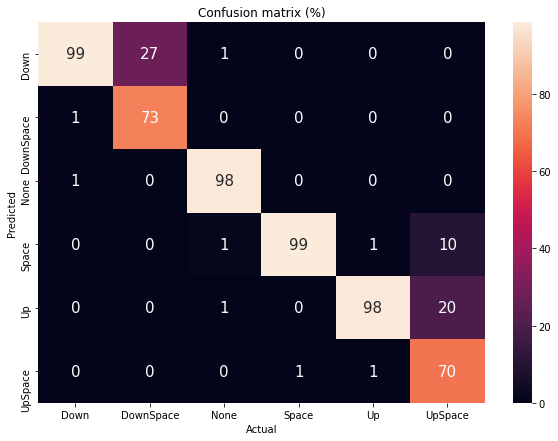

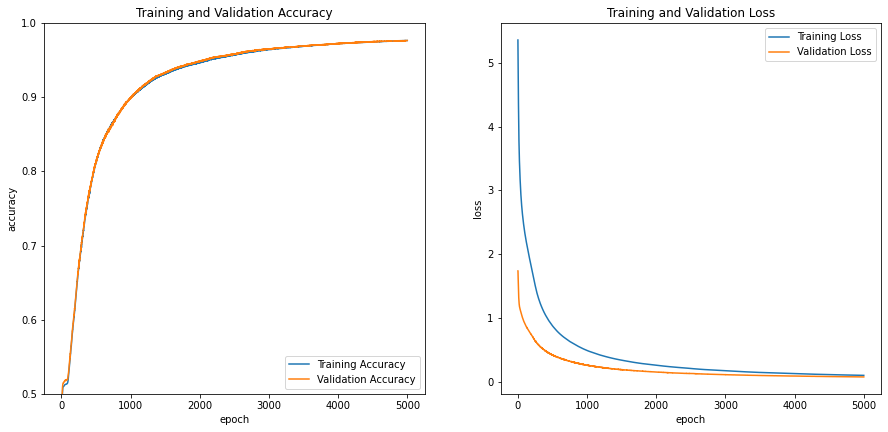

In [189]:
printGraphs(t_final, val_X, y_test, results_final, 5000)

In [209]:
np.argmax(t_final(np.array([[0.0, 1.0, 0.9084771199999999, 1.0, 0.34290803, -0.04963248, 1.0, 0.0082102, 0.726495, -0.5, 0.0]])))

4

In [200]:
t_final.save('t_final.sav')

INFO:tensorflow:Assets written to: t_final.sav\assets
